# Класифікація і кластеризація книг
Виконала Трущак О. І.
ІП-з11

### Вступ

В даній роботі здійснена класифікація та кластеризація книг на прикладі бібліотечного фонду міста Сієтл. 

Перша частина роботи присвячена дослідженню даних із вибірки книг розміром в 10 000 записів. Розглянуті способи очищення даних різних форматів за допомогою регулярних виразів, використання спеціалізованих NLP бібліотек та виділення нестандартизованих сутностей в даних рядкового типу за допомогою кластеризації на підставі ортографічної відстані. 

В другій частині роботи реалізований алгоритм збагачення даних додатковими параметрами з використанням зовнішніх джерел даних. Для збагачених даних здійснене порівняння алгоритмів кластеризації K-means і Agglomerative та алгоритмів класифікації Random forest, Support Vector Machines і Gradient boosting. Для кожного з алгоритмів як класифікації так і кластеризації здійснене порівняння роботи з використанням даних про назву книги і без використання цих даних.

В третій частині роботи розглянута класифікація за алгоритмами Random forest, Support Vector Machines і Gradient boosting для основних даних, які не були збагачені параметрами із зовнішніх джерел. Виконане порівняння точності класифікації вказаними алгоритмами для великих обсягів вибірки з обмеженою кількістю числових параметрів та відносно малих обсягів вибірки, яка була збагачена числовими даними із зовнішніх джерел, і була описана та проаналізована в другій частині роботи.

Робота виконана у Jupyter notebook на мові програмування Python із використанням програмних бібліотек аналізу даних, що знаходяться у вільному доступі. Структура роботи дозволяє запустити всі клітинки підряд для отримання коректних результатів. До роботи додаються файли:
1. 'sample_final.csv' - містить вибірку розміром не менше 10 000 записів із бази даних бібліотечного фонду міста Сієтл
2. 'goodreads_data.csv' - містить компактно збережені дані про ISBN, кількість сторінок та рейтинг книги із відповідним ISBN, які використовуються в межах роботи для збагачення основної вибірки числовими даними.
3. 'CollectionInventory_Codes_EXCLUDED_INCLUDED.xlsx' - містить розшифровку кодів типу та колекції книг

### Опис джерела даних та їх отримання

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Дані про книги отримані з американського державного бібліотечного реєстру міста Сієтл, який можна знайти за посиланням https://data.seattle.gov/Community/Library-Collection-Inventory/6vkj-f5xf . У даному реєстрі міститься інформація про: унікальний бібліотечний ідентифікатор, повну назву предмета, ім'я автора, ISBN, рік публікації, видавця, тематики, тип предмета, колекція до якої належить предмет, індикатор неналежності предмету до конкретної локації, місцезнаходження предмета, дата надходження до бібліотечного фонду та кількість таких предметів в бібліотечному фонді. 

Вказане джерело даних містить не лише книги, а й інші предмети, які можуть знаходитися в бібліотечному фонді, зокрема дискети, відео та аудіо касети, CD і DVD диски, журнали, мікрофільми, аудіозаписи, слайди та інше. Інформація про те, якому саме типу предмета відповідає запис в базі даних міститься у стовпчику 'ItemType'. Типи в базі даних містяться під кодовими назвами, їхню розшифровку можна знайти у файлі 'CollectionInventory_Codes_EXCLUDED_INCLUDED.xlsx'. Здійснивши дослідження вищенаведеної розшифровки, легко бачити, що для виділення із бази даних предметів лише паперових книг достатньо знайти всі предмети, в яких код типу предмету відповідає одному з наведених: 'bcbk', 'acbk', 'ahbk', 'jcbk', 'arbk', 'jrbk'.

Даний бібліотечний фонд містить предмети, назви та вміст яких не обов'язково є англомовним. Попереднє дослідження набору даних продемонструвало, що більшість неангломовних предметів належать до колекцій, які, згідно файлу 'CollectionInventory_Codes_EXCLUDED_INCLUDED.xlsx', містять в своєму описі слово Language. Крім цього, якщо попередньо відфільтрувати дані на предмет того, що за своїм типом відповідають книгам, достатньо не включати у вибірку лише ті неангломовні колекції, які стосуються книг. Інформацію про групу типів предметів, яких стосується колекція, можна знайти у описовому файлі в стовпчиках 'FormatGroup' і 'FormatSubgroup'. Такими колекціями є: 'caln', 'calnr', 'ccln', 'naln', 'nalnpb', 'ncln', 'cs1lew' та 'cs1lewr'.

Кожна книга в межах обраної для аналізу бази даних ідентифікується унікальним бібліотечним номером, проте цей ідентифікатор діє лише в межах цієї бази даних і не є універсальним. У випадку книг найкращим ідентифікатором слугуватиме ISBN, що дозволить надалі додавати до отриманої вибірки інформацію з інших джерел для аналізу, наприклад, кількість сторінок і зображення обкладинки. Попереднє дослідження вибірки, яка включає лише книги, продемонструвало, що в більшості випадків, коли дані про ISBN книги відсутні, даний предмет є або неангломовною книгою або п'єсою. Таким чином, виключення із вибірки предметів, ISBN яких відсутній в базі даних, найімовірніше, не завдасть вибірці жодної шкоди а лише покращить її розширюваність та здатність до модифікації.

Повна база даних на момент здачі роботи містить приблизно 116 000 000 предметів і оновлюється щомісяця. Оскільки аналіз такого об'єму даних вимагає значних комп'ютерних потужностей, було прийняте рішення виділити з даного джерела вибірку із 10 000 предметів, які є англомовними книгами що містять дані про присвоєний їм ISBN. 

In [2]:
def get_english_books_with_isbn(min_number_of_records = 1000, database_location = r'C:\Users\trush\Downloads\Library_Collection_Inventory_20231102.csv'):
    i = 1
    book_codes = ['bcbk', 'acbk', 'ahbk', 'jcbk', 'arbk', 'jrbk']
    column_names = ['BibNum', 'Title', 'Author', 'ISBN', 'PublicationYear', 'Publisher', 'Subjects', 'ItemType', 'ItemCollection', 'FloatingItem', 'ItemLocation', 'ReportDate', 'ItemCount']
    language_collections = ['caln', 'calnr', 'ccln', 'naln', 'nalnpb', 'ncln', 'cs1lew', 'cs1lewr']
    books = pd.DataFrame()
    while books.shape[0] < min_number_of_records:
        temp = pd.read_csv(r'C:\Users\trush\Downloads\Library_Collection_Inventory_20231102.csv', on_bad_lines='skip', skiprows=i, nrows=1000, header=None, names=column_names)
        temp = temp.loc[temp['ItemType'].isin(book_codes)]
        temp = temp.loc[~temp['ItemCollection'].isin(language_collections)]
        temp = temp.loc[temp['ISBN'].notna()]
        books = pd.concat([books, temp], ignore_index=True)
        i += 1000
    return books

In [3]:
books_sample = get_english_books_with_isbn(10000)

Отриману вибірку виносимо у зовнішній файл для подальшого перетворення та очищення даних. Створена функція дозволяє за потреби отримати вибірку інших розмірів та, за незначних модифікацій, здійснювати фільтрування предметів з іншої бази даних та з іншої стартової точки. 

In [4]:
books_sample.to_csv('sample_final.csv', index=False)

### Обробка даних

In [5]:
books = pd.read_csv('sample_final.csv')
books

,BibNum,Title,Author,ISBN,PublicationYear,Publisher,Subjects,ItemType,ItemCollection,FloatingItem,ItemLocation,ReportDate,ItemCount
0,3479509,Franklin and Luna and the book of fairy tales ...,"Campbell, Jen","0500651752, 9780500651759",2019.,"Thames and Hudson,","Dragons Juvenile fiction, Characters and chara...",jcbk,ncnew,NaN,net,03/01/2020,1
1,2737917,Holiday dinners with Bradley Ogden : 150 festi...,"Ogden, Bradley","0762439157, 9780762439157",[2011],"Running Press,","Cooking, Holiday cooking",acbk,nanf,NaN,swt,12/01/2020,1
2,3359831,"Cuzco, Machu Picchu & the Inca heartland / Rob...","Kunstaetter, Robert","1911082256, 9781911082255",2017.,"Footprint,","Peru Guidebooks, Cuzco Peru Guidebooks, Machu ...",acbk,nanf,NaN,wts,03/01/2020,1
3,3298424,Sleeping Beauty / retold by Cynthia Rylant ; p...,"Rylant, Cynthia","1423121082, 9781423121084",[2015],"Disney Hyperion,","Sleeping Beauty Tale Juvenile literature, Folk...",jcbk,ncfft,NaN,mag,11/01/2020,1
4,3203995,How to escape from a leper colony : a novella ...,"Yanique, Tiphanie","155597550X, 9781555975500",2010.,"Graywolf Press,","United States Virgin Islands Fiction, Short st...",acbk,cafic,NaN,cen,05/01/2020,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10244,2760306,Lover reborn / J.R. Ward.,"Ward, J. R., 1969-","0451235843, 9780451235848",[2012],"New American Library,","Vampires Fiction, Paranormal romance stories, ...",acbk,nafic,NaN,dlr,10/01/2020,1
10245,2724228,Experimental drawing / Robert Kaupelis.,"Kaupelis, Robert","0823016188, 0823016226, 9780823016181, 9780823...",[1980],"Watson-Guptill Publications,","Drawing Study and teaching, Drawing Technique",acbk,nanf,NaN,rbe,09/01/2020,1
10246,3364815,The bad guys in Alien vs. Bad Guys / Aaron Bla...,"Blabey, Aaron","133818959X, 9781338189599",[2018],"Scholastic Inc.,","Extraterrestrial beings Juvenile fiction, Kidn...",jcbk,ncef,NaN,glk,10/01/2020,1
10247,3227571,English for everyone. Course book. Level 3 int...,"Johnson, Gill, 1964-","1465447636, 1465449418, 9781465447630, 9781465...",2016.,"DK Publishing,","English language Self instruction, English lan...",bcbk,naesli,NaN,col,03/01/2020,1


In [6]:
books.isna().sum()

BibNum                0
Title                 0
Author              545
ISBN                  0
PublicationYear       1
Publisher             5
Subjects             94
ItemType              0
ItemCollection        0
FloatingItem       9802
ItemLocation          0
ReportDate            0
ItemCount             0
dtype: int64

Аналіз отриманої вибірки на предмет відсутніх даних демонструє, що індикатор неналежності предмету до конкретної локації є відсутнім значенням для практично всієї вибірки. Даний показник є за визначенням бінарним, відсутніх значень можна позбутися заповнивши їх нулями або рядковими значеннями, наприклад, 'NotFloating'. Проте, в такому випадку розподіл даних значень буде дуже нерівномірним, що при аналізі принесе більше шкоди аніж користі. Таким чином було прийняте рішення в даній вибірці цей індикатор не враховувати, тому стовпчика 'FloatingItem' можна позбутися.

In [7]:
books = books.drop('FloatingItem', axis=1)
books

,BibNum,Title,Author,ISBN,PublicationYear,Publisher,Subjects,ItemType,ItemCollection,ItemLocation,ReportDate,ItemCount
0,3479509,Franklin and Luna and the book of fairy tales ...,"Campbell, Jen","0500651752, 9780500651759",2019.,"Thames and Hudson,","Dragons Juvenile fiction, Characters and chara...",jcbk,ncnew,net,03/01/2020,1
1,2737917,Holiday dinners with Bradley Ogden : 150 festi...,"Ogden, Bradley","0762439157, 9780762439157",[2011],"Running Press,","Cooking, Holiday cooking",acbk,nanf,swt,12/01/2020,1
2,3359831,"Cuzco, Machu Picchu & the Inca heartland / Rob...","Kunstaetter, Robert","1911082256, 9781911082255",2017.,"Footprint,","Peru Guidebooks, Cuzco Peru Guidebooks, Machu ...",acbk,nanf,wts,03/01/2020,1
3,3298424,Sleeping Beauty / retold by Cynthia Rylant ; p...,"Rylant, Cynthia","1423121082, 9781423121084",[2015],"Disney Hyperion,","Sleeping Beauty Tale Juvenile literature, Folk...",jcbk,ncfft,mag,11/01/2020,1
4,3203995,How to escape from a leper colony : a novella ...,"Yanique, Tiphanie","155597550X, 9781555975500",2010.,"Graywolf Press,","United States Virgin Islands Fiction, Short st...",acbk,cafic,cen,05/01/2020,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10244,2760306,Lover reborn / J.R. Ward.,"Ward, J. R., 1969-","0451235843, 9780451235848",[2012],"New American Library,","Vampires Fiction, Paranormal romance stories, ...",acbk,nafic,dlr,10/01/2020,1
10245,2724228,Experimental drawing / Robert Kaupelis.,"Kaupelis, Robert","0823016188, 0823016226, 9780823016181, 9780823...",[1980],"Watson-Guptill Publications,","Drawing Study and teaching, Drawing Technique",acbk,nanf,rbe,09/01/2020,1
10246,3364815,The bad guys in Alien vs. Bad Guys / Aaron Bla...,"Blabey, Aaron","133818959X, 9781338189599",[2018],"Scholastic Inc.,","Extraterrestrial beings Juvenile fiction, Kidn...",jcbk,ncef,glk,10/01/2020,1
10247,3227571,English for everyone. Course book. Level 3 int...,"Johnson, Gill, 1964-","1465447636, 1465449418, 9781465447630, 9781465...",2016.,"DK Publishing,","English language Self instruction, English lan...",bcbk,naesli,col,03/01/2020,1


#### ISBN

ISBN - міжнародний унікальний ідентифікатор книги, який присвоюється окремо кожному виданню. До 2007 року стандартом був формат ISBN-10, який складався з десяти цифер, де X може позначати число 10 в чексумі. З 2007-го книгам присвоюється тільки ISBN-13, який складається з тринадцяти цифер. Реєструється видавничою групою через локальне ISBN агентство, тому, ймовірно, між ISBN та видавництвом буде помітна кореляція. Видавнича група може звернутися до ISBN агентства із запитом додати для книги за наявного ISBN-10 відповідний ISBN-13. Саме тому, в нашій вибірці ми спостерігаємо кілька ISBN на одну книгу, а іноді для однієї книги і кілька наборів ISBN-10 і ISBN-13.

В межах даної вибірки кожна книга має хоча б одне значення ISBN. Для подальшого аналізу виділимо всі дані про ISBN в окремий датафрейм, при чому, через наявність в ISBN-10 символу X для позначення 10, та, з метою подальшого розділення на ISBN-10 та ISBN-13 за допомогою регулярних виразів, будемо розглядати значення отриманого стовпчика як рядкового типу.

In [8]:
isbn_df = books['ISBN'].copy().to_frame(name='ISBN_dirty')
isbn_df['ISBN_dirty'] = isbn_df['ISBN_dirty'].astype('string')
isbn_df

,ISBN_dirty
0,"0500651752, 9780500651759"
1,"0762439157, 9780762439157"
2,"1911082256, 9781911082255"
3,"1423121082, 9781423121084"
4,"155597550X, 9781555975500"
...,...
10244,"0451235843, 9780451235848"
10245,"0823016188, 0823016226, 9780823016181, 9780823..."
10246,"133818959X, 9781338189599"
10247,"1465447636, 1465449418, 9781465447630, 9781465..."


Тепер можна легко перетворити рядкові значення у список всіх наявних в базі даних ISBN для кожної книги.

In [9]:
isbn_df['ISBN_list'] = isbn_df['ISBN_dirty'].str.split(', ').tolist()
isbn_df

,ISBN_dirty,ISBN_list
0,"0500651752, 9780500651759","[0500651752, 9780500651759]"
1,"0762439157, 9780762439157","[0762439157, 9780762439157]"
2,"1911082256, 9781911082255","[1911082256, 9781911082255]"
3,"1423121082, 9781423121084","[1423121082, 9781423121084]"
4,"155597550X, 9781555975500","[155597550X, 9781555975500]"
...,...,...
10244,"0451235843, 9780451235848","[0451235843, 9780451235848]"
10245,"0823016188, 0823016226, 9780823016181, 9780823...","[0823016188, 0823016226, 9780823016181, 978082..."
10246,"133818959X, 9781338189599","[133818959X, 9781338189599]"
10247,"1465447636, 1465449418, 9781465447630, 9781465...","[1465447636, 1465449418, 9781465447630, 978146..."


За допомогою регулярних виразів здійснимо видобування зі списків по одному відповідному значенню ISBN. Це зручно виконати застосуванням функцій на відповідний стовпчик. Хоча, за наявності кількох наборів ISBN-10 і ISBN-13 для однієї позиції ми в результаті отримуємо лише один, який використовуватиметься як основний, зберігаючи всі наявні дані про ISBN в списку, ми все ще залишаємо за собою можливість звернутися до інших версій за потреби.

In [10]:
import re

In [11]:
def check_isbn_10(isbn_list):
    isbn_10 = r"^(?:ISBN(?:-10)?:?\ )?(?=[0-9X]{10}$|(?=(?:[0-9]+[-\ ]){3})[-\ 0-9X]{13}$)[0-9]{1,5}[-\ ]?[0-9]+[-\ ]?[0-9]+[-\ ]?[0-9X]$"
    for i in range(len(isbn_list)):
        if re.search(isbn_10, isbn_list[i]) is not None:
            return isbn_list[i]
    return None

def check_isbn_13(isbn_list):
    isbn_13 = r"^(?:ISBN(?:-13)?:?\ )?(?=[0-9]{13}$|(?=(?:[0-9]+[-\ ]){4})[-\ 0-9]{17}$)97[89][-\ ]?[0-9]{1,5}[-\ ]?[0-9]+[-\ ]?[0-9]+[-\ ]?[0-9]$"
    for i in range(len(isbn_list)):
        if re.search(isbn_13, isbn_list[i]) is not None:
            return isbn_list[i]
    return None

In [12]:
isbn_df['ISBN10'] = isbn_df['ISBN_list'].apply(check_isbn_10)
isbn_df['ISBN13'] = isbn_df['ISBN_list'].apply(check_isbn_13)
isbn_df

,ISBN_dirty,ISBN_list,ISBN10,ISBN13
0,"0500651752, 9780500651759","[0500651752, 9780500651759]",0500651752,9780500651759
1,"0762439157, 9780762439157","[0762439157, 9780762439157]",0762439157,9780762439157
2,"1911082256, 9781911082255","[1911082256, 9781911082255]",1911082256,9781911082255
3,"1423121082, 9781423121084","[1423121082, 9781423121084]",1423121082,9781423121084
4,"155597550X, 9781555975500","[155597550X, 9781555975500]",155597550X,9781555975500
...,...,...,...,...
10244,"0451235843, 9780451235848","[0451235843, 9780451235848]",0451235843,9780451235848
10245,"0823016188, 0823016226, 9780823016181, 9780823...","[0823016188, 0823016226, 9780823016181, 978082...",0823016188,9780823016181
10246,"133818959X, 9781338189599","[133818959X, 9781338189599]",133818959X,9781338189599
10247,"1465447636, 1465449418, 9781465447630, 9781465...","[1465447636, 1465449418, 9781465447630, 978146...",1465447636,9781465447630


Оцінимо для даної вибірки, яка версія ISBN більш придатна для того, щоб використовуватись для видобування додаткових даних.

In [13]:
isbn_df.isna().sum()

ISBN_dirty       0
ISBN_list        0
ISBN10          31
ISBN13        1498
dtype: int64

Робимо висновок, що оскільки відсутніх даних про ISBN-10 значно менше, ніж про ISBN-13, саме перший з цих форматів краще підходить для формування потенційних запитів на додаткові дані з інших баз даних.

Отримані дані можна додати як стовпці до базового датафрейму книг і позбутися стовпчика із неочищеними даними про ISBN.

In [14]:
books.insert(3, 'ISBN13', isbn_df['ISBN13'])
books.insert(3, 'ISBN10', isbn_df['ISBN10'])
books

,BibNum,Title,Author,ISBN10,ISBN13,ISBN,PublicationYear,Publisher,Subjects,ItemType,ItemCollection,ItemLocation,ReportDate,ItemCount
0,3479509,Franklin and Luna and the book of fairy tales ...,"Campbell, Jen",0500651752,9780500651759,"0500651752, 9780500651759",2019.,"Thames and Hudson,","Dragons Juvenile fiction, Characters and chara...",jcbk,ncnew,net,03/01/2020,1
1,2737917,Holiday dinners with Bradley Ogden : 150 festi...,"Ogden, Bradley",0762439157,9780762439157,"0762439157, 9780762439157",[2011],"Running Press,","Cooking, Holiday cooking",acbk,nanf,swt,12/01/2020,1
2,3359831,"Cuzco, Machu Picchu & the Inca heartland / Rob...","Kunstaetter, Robert",1911082256,9781911082255,"1911082256, 9781911082255",2017.,"Footprint,","Peru Guidebooks, Cuzco Peru Guidebooks, Machu ...",acbk,nanf,wts,03/01/2020,1
3,3298424,Sleeping Beauty / retold by Cynthia Rylant ; p...,"Rylant, Cynthia",1423121082,9781423121084,"1423121082, 9781423121084",[2015],"Disney Hyperion,","Sleeping Beauty Tale Juvenile literature, Folk...",jcbk,ncfft,mag,11/01/2020,1
4,3203995,How to escape from a leper colony : a novella ...,"Yanique, Tiphanie",155597550X,9781555975500,"155597550X, 9781555975500",2010.,"Graywolf Press,","United States Virgin Islands Fiction, Short st...",acbk,cafic,cen,05/01/2020,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10244,2760306,Lover reborn / J.R. Ward.,"Ward, J. R., 1969-",0451235843,9780451235848,"0451235843, 9780451235848",[2012],"New American Library,","Vampires Fiction, Paranormal romance stories, ...",acbk,nafic,dlr,10/01/2020,1
10245,2724228,Experimental drawing / Robert Kaupelis.,"Kaupelis, Robert",0823016188,9780823016181,"0823016188, 0823016226, 9780823016181, 9780823...",[1980],"Watson-Guptill Publications,","Drawing Study and teaching, Drawing Technique",acbk,nanf,rbe,09/01/2020,1
10246,3364815,The bad guys in Alien vs. Bad Guys / Aaron Bla...,"Blabey, Aaron",133818959X,9781338189599,"133818959X, 9781338189599",[2018],"Scholastic Inc.,","Extraterrestrial beings Juvenile fiction, Kidn...",jcbk,ncef,glk,10/01/2020,1
10247,3227571,English for everyone. Course book. Level 3 int...,"Johnson, Gill, 1964-",1465447636,9781465447630,"1465447636, 1465449418, 9781465447630, 9781465...",2016.,"DK Publishing,","English language Self instruction, English lan...",bcbk,naesli,col,03/01/2020,1


In [15]:
books = books.drop('ISBN', axis=1)
books

,BibNum,Title,Author,ISBN10,ISBN13,PublicationYear,Publisher,Subjects,ItemType,ItemCollection,ItemLocation,ReportDate,ItemCount
0,3479509,Franklin and Luna and the book of fairy tales ...,"Campbell, Jen",0500651752,9780500651759,2019.,"Thames and Hudson,","Dragons Juvenile fiction, Characters and chara...",jcbk,ncnew,net,03/01/2020,1
1,2737917,Holiday dinners with Bradley Ogden : 150 festi...,"Ogden, Bradley",0762439157,9780762439157,[2011],"Running Press,","Cooking, Holiday cooking",acbk,nanf,swt,12/01/2020,1
2,3359831,"Cuzco, Machu Picchu & the Inca heartland / Rob...","Kunstaetter, Robert",1911082256,9781911082255,2017.,"Footprint,","Peru Guidebooks, Cuzco Peru Guidebooks, Machu ...",acbk,nanf,wts,03/01/2020,1
3,3298424,Sleeping Beauty / retold by Cynthia Rylant ; p...,"Rylant, Cynthia",1423121082,9781423121084,[2015],"Disney Hyperion,","Sleeping Beauty Tale Juvenile literature, Folk...",jcbk,ncfft,mag,11/01/2020,1
4,3203995,How to escape from a leper colony : a novella ...,"Yanique, Tiphanie",155597550X,9781555975500,2010.,"Graywolf Press,","United States Virgin Islands Fiction, Short st...",acbk,cafic,cen,05/01/2020,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10244,2760306,Lover reborn / J.R. Ward.,"Ward, J. R., 1969-",0451235843,9780451235848,[2012],"New American Library,","Vampires Fiction, Paranormal romance stories, ...",acbk,nafic,dlr,10/01/2020,1
10245,2724228,Experimental drawing / Robert Kaupelis.,"Kaupelis, Robert",0823016188,9780823016181,[1980],"Watson-Guptill Publications,","Drawing Study and teaching, Drawing Technique",acbk,nanf,rbe,09/01/2020,1
10246,3364815,The bad guys in Alien vs. Bad Guys / Aaron Bla...,"Blabey, Aaron",133818959X,9781338189599,[2018],"Scholastic Inc.,","Extraterrestrial beings Juvenile fiction, Kidn...",jcbk,ncef,glk,10/01/2020,1
10247,3227571,English for everyone. Course book. Level 3 int...,"Johnson, Gill, 1964-",1465447636,9781465447630,2016.,"DK Publishing,","English language Self instruction, English lan...",bcbk,naesli,col,03/01/2020,1


#### Рік публікації

Наступний стовпчик, що потребує очищення - рік публікації. У кожної книги може бути тільки один рік публікації і, в межах цієї вибірки, рік буде чотиризначним цифровим значенням у стовпчику 'PublicationYear'. В даному випадку очищення можна здійснити "на місці".

In [16]:
books['PublicationYear'] = books['PublicationYear'].str.replace(r'\D', '', regex=True)
books

,BibNum,Title,Author,ISBN10,ISBN13,PublicationYear,Publisher,Subjects,ItemType,ItemCollection,ItemLocation,ReportDate,ItemCount
0,3479509,Franklin and Luna and the book of fairy tales ...,"Campbell, Jen",0500651752,9780500651759,2019,"Thames and Hudson,","Dragons Juvenile fiction, Characters and chara...",jcbk,ncnew,net,03/01/2020,1
1,2737917,Holiday dinners with Bradley Ogden : 150 festi...,"Ogden, Bradley",0762439157,9780762439157,2011,"Running Press,","Cooking, Holiday cooking",acbk,nanf,swt,12/01/2020,1
2,3359831,"Cuzco, Machu Picchu & the Inca heartland / Rob...","Kunstaetter, Robert",1911082256,9781911082255,2017,"Footprint,","Peru Guidebooks, Cuzco Peru Guidebooks, Machu ...",acbk,nanf,wts,03/01/2020,1
3,3298424,Sleeping Beauty / retold by Cynthia Rylant ; p...,"Rylant, Cynthia",1423121082,9781423121084,2015,"Disney Hyperion,","Sleeping Beauty Tale Juvenile literature, Folk...",jcbk,ncfft,mag,11/01/2020,1
4,3203995,How to escape from a leper colony : a novella ...,"Yanique, Tiphanie",155597550X,9781555975500,2010,"Graywolf Press,","United States Virgin Islands Fiction, Short st...",acbk,cafic,cen,05/01/2020,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10244,2760306,Lover reborn / J.R. Ward.,"Ward, J. R., 1969-",0451235843,9780451235848,2012,"New American Library,","Vampires Fiction, Paranormal romance stories, ...",acbk,nafic,dlr,10/01/2020,1
10245,2724228,Experimental drawing / Robert Kaupelis.,"Kaupelis, Robert",0823016188,9780823016181,1980,"Watson-Guptill Publications,","Drawing Study and teaching, Drawing Technique",acbk,nanf,rbe,09/01/2020,1
10246,3364815,The bad guys in Alien vs. Bad Guys / Aaron Bla...,"Blabey, Aaron",133818959X,9781338189599,2018,"Scholastic Inc.,","Extraterrestrial beings Juvenile fiction, Kidn...",jcbk,ncef,glk,10/01/2020,1
10247,3227571,English for everyone. Course book. Level 3 int...,"Johnson, Gill, 1964-",1465447636,9781465447630,2016,"DK Publishing,","English language Self instruction, English lan...",bcbk,naesli,col,03/01/2020,1


Також приймаємо, що кожна книга з присвоєним ISBN видана конкретним видавцем. Легко бачити, що дані в стовпчику, який містить інформацію про видавця, є помітно забрудненими, тому, для зручності очищення, найкраще винести його в окремий датафрейм. На відміну від ISBN, де ми припускали, що код для кожної книги є унікальним саме для неї, один видавець може мати множину відповідних книг у базі.

#### Видавець

In [17]:
publisher_df = pd.DataFrame()

In [18]:
publisher_df = books['Publisher'].copy().to_frame(name='Publisher_dirty')
publisher_df

,Publisher_dirty
0,"Thames and Hudson,"
1,"Running Press,"
2,"Footprint,"
3,"Disney Hyperion,"
4,"Graywolf Press,"
...,...
10244,"New American Library,"
10245,"Watson-Guptill Publications,"
10246,"Scholastic Inc.,"
10247,"DK Publishing,"


Створимо функцію для очистки текстових даних. Вважаємо, що всі назви видавництв, які в рядку йдуть після слешу '/' є альтернативними, тож їх можна відкинути. Всі спецзнаки і посилання мають бути відкинуті. Назви видавництв повинні бути у ловеркейсі, між словами має йти одиночний пробіл.

In [19]:
def clean_publisher(publisher_name_dirty):
    publisher_name_clean = "None"
    if not publisher_name_dirty is None:
        publisher_name_clean = publisher_name_dirty.strip(',')
        publisher_name_clean = publisher_name_clean.lower()
        publisher_name_clean = publisher_name_clean.split("/")[0]
        publisher_name_clean = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", publisher_name_clean)
        publisher_name_clean = re.sub(r" +", " ", publisher_name_clean)
        #print(publisher_name_clean)
    return publisher_name_clean

Переводимо дані у рядковий тип і застосуємо отриману функцію.

In [20]:
publisher_df['Publisher_dirty'] = publisher_df['Publisher_dirty'].astype('string')
publisher_df['Publisher_dirty'] = publisher_df['Publisher_dirty'].fillna('None')
publisher_df['Publisher_clean'] = publisher_df['Publisher_dirty'].apply(clean_publisher)
publisher_df

,Publisher_dirty,Publisher_clean
0,"Thames and Hudson,",thames and hudson
1,"Running Press,",running press
2,"Footprint,",footprint
3,"Disney Hyperion,",disney hyperion
4,"Graywolf Press,",graywolf press
...,...,...
10244,"New American Library,",new american library
10245,"Watson-Guptill Publications,",watson guptill publications
10246,"Scholastic Inc.,",scholastic inc
10247,"DK Publishing,",dk publishing


Після базової очистки тексту бачимо, що назви видавництв, які повинні бути однією сутністю, часто відрізняються доданими суфіксами, що не є оптимальним. Навіть дані суфікси можуть бути записані в межах вибірки по-різному, наприклад, одна назва містить слово 'pub', а інша використовує повне 'publishing'. Крім цього, деякі видавництва є частиною певної видавничої групи або підрозділом іншого видавництва. В даній вибірці не для всіх записів про назву видавництва вказано чи є воно підрозділом іншого видавництва. Таким чином, для того, щоб чітко виділити сутності, краще позбутися як вищезгаданих суфіксів, так і додаткової інформації про батьківське видавництво або видавничу групу.

In [21]:
publisher_suffixes = ['publishing', 'press', 'books', 'co', 'book', 'publishers', 'pub', 'press', 'entertainment', 'media', 'publications', 'production', 'company', 'collection', 'illustrated', 'ink', 'ltd', 'publication', 'group', 'paperback', 'house', 'inc', 'company', 'productions', 'llc', 's', 'an', 'a']
publisher_imprint = ['imprint', 'an imprint', 'a division', 'published', 'books', 'in association', 'distributed', 'are imprints', 'a member', 'press of', 'large print']

До суфіксів publisher_suffixes також входять деякі артиклі і вставні слова, що можуть залишатися після видалення додаткової інформації з назви. Інформація про батьківське видавництво повинна видалятися починаючи зі слів у списку publisher_imprint до кінця рядка, включно із зазначеним словом. Суфікси повинні видалятися чітко після видалення даних про батьківське видавництво. Отримані списки були зібрані методом звичайного перегляду вибірки і не є вичерпними.

In [22]:
publisher_df['Publisher_clean_imprints'] = publisher_df['Publisher_clean']
for pub_imp in publisher_imprint:
    pattern = re.compile(f'\\b{pub_imp}\\b.*$')
    publisher_df['Publisher_clean_imprints'] = publisher_df['Publisher_clean_imprints'].apply(lambda x: re.sub(pattern, '', str(x)))
publisher_df

,Publisher_dirty,Publisher_clean,Publisher_clean_imprints
0,"Thames and Hudson,",thames and hudson,thames and hudson
1,"Running Press,",running press,running press
2,"Footprint,",footprint,footprint
3,"Disney Hyperion,",disney hyperion,disney hyperion
4,"Graywolf Press,",graywolf press,graywolf press
...,...,...,...
10244,"New American Library,",new american library,new american library
10245,"Watson-Guptill Publications,",watson guptill publications,watson guptill publications
10246,"Scholastic Inc.,",scholastic inc,scholastic inc
10247,"DK Publishing,",dk publishing,dk publishing


In [23]:
publisher_df['Publisher_clean_imprints_cut'] = publisher_df['Publisher_clean_imprints']
for pub_suf in publisher_suffixes:
    pattern_1 = re.compile(f'\\b{pub_suf}\\b')
    publisher_df['Publisher_clean_imprints_cut'] = publisher_df['Publisher_clean_imprints_cut'].apply(lambda x: re.sub(pattern_1, '', str(x)))
publisher_df

,Publisher_dirty,Publisher_clean,Publisher_clean_imprints,Publisher_clean_imprints_cut
0,"Thames and Hudson,",thames and hudson,thames and hudson,thames and hudson
1,"Running Press,",running press,running press,running
2,"Footprint,",footprint,footprint,footprint
3,"Disney Hyperion,",disney hyperion,disney hyperion,disney hyperion
4,"Graywolf Press,",graywolf press,graywolf press,graywolf
...,...,...,...,...
10244,"New American Library,",new american library,new american library,new american library
10245,"Watson-Guptill Publications,",watson guptill publications,watson guptill publications,watson guptill
10246,"Scholastic Inc.,",scholastic inc,scholastic inc,scholastic
10247,"DK Publishing,",dk publishing,dk publishing,dk


In [24]:
publisher_df['Publisher_clean_imprints_cut'] = publisher_df['Publisher_clean_imprints_cut'].str.strip()
publisher_df['Publisher_clean_imprints_cut'] = publisher_df['Publisher_clean_imprints_cut'].apply(lambda x: re.sub(r" +", ' ', str(x)))
publisher_df

,Publisher_dirty,Publisher_clean,Publisher_clean_imprints,Publisher_clean_imprints_cut
0,"Thames and Hudson,",thames and hudson,thames and hudson,thames and hudson
1,"Running Press,",running press,running press,running
2,"Footprint,",footprint,footprint,footprint
3,"Disney Hyperion,",disney hyperion,disney hyperion,disney hyperion
4,"Graywolf Press,",graywolf press,graywolf press,graywolf
...,...,...,...,...
10244,"New American Library,",new american library,new american library,new american library
10245,"Watson-Guptill Publications,",watson guptill publications,watson guptill publications,watson guptill
10246,"Scholastic Inc.,",scholastic inc,scholastic inc,scholastic
10247,"DK Publishing,",dk publishing,dk publishing,dk


Виділяємо унікальне написання видавців, факторизуючи очищені і обрізані назви видавців. Найзручніше буде виділити для унікальних написаннь окремий датафрейм, на який таблиця publisher_df має посилання і над яким ми можемо здійснювати подальші кроки з очищення і нормалізації.

In [25]:
publisher_unique_df = pd.DataFrame()
publisher_df['FK_id'], publisher_unique_df['Publisher'] = pd.factorize(publisher_df['Publisher_clean_imprints_cut'])
publisher_unique_df

,Publisher
0,thames and hudson
1,running
2,footprint
3,disney hyperion
4,graywolf
...,...
2173,charnwood
2174,combat studies institute us army combined arms...
2175,chatto windus norton
2176,catholic university of america


#### Кластеризація видавців в межах обробки даних

Розсортувавши дану вибірку в алфавітному порядку, легко бачити що, хоча, звичайне очищення тексту значно зменшило кількість унікальних видавців, проте ми все ще легко знаходимо назви, які явно належать одній сутності з відмінностями в написанні. Більше того, частина відмінностей між виділеними назвами видавництв, очевидно, пов'язана з одруками та використанням унікальних суфіксів, що позначають підрозділи конкретного видавництва. З цього можна зробити висновок, що отримана вибірка придатна до подальшого очищення. Крім цього, суть відмінностей у отриманих назвах видавництв наштовхує на думку, що для очищення слід скористатися певними метриками відстані між рядковими значеннями.

Для даного очищення такою метрикою була обрана відстань Левенштайна, яка визначає кількість змін, які необхідно здійснити над одним рядковим літералом для перетворення його в інший. Дана метрика добре працює для коротких рядків, якими і є наші назви видавництв.

Якби у нас був наявний список всіх допустимих видавництв, задача би звелась до порівняння назв видавництв із вибірки з правильними назвами і заміною назви з вибірки на найкращий відповідник. Однак, за відсутності такого списку, перед нами стоїть задача кластеризації. На даній вибірці дуже непогано працює K-means кластеринг з кількістю кластерів в розмірі приблизно третини вибірки. Така кількість кластерів виявлена експериментально для цієї конкретної вибірки в ході роботи і може бути уточнена або змінена для інших даних. Один або більше кластерів виявляться такими, що містять змішані дані, в той час, як решта - дані з малою ортографічною відстанню між собою, достатньою для того, щоб їх можна було вважати однією сутністю.

In [26]:
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [27]:
def compute_similarity(publisher1, publisher2):
    return 100 - fuzz.ratio(publisher1, publisher2)

In [28]:
unique_publishers = publisher_unique_df['Publisher'].unique()

similarity_matrix = pd.DataFrame(index=unique_publishers, columns=unique_publishers)
for publisher1 in unique_publishers:
    for publisher2 in unique_publishers:
        similarity_matrix.loc[publisher1, publisher2] = compute_similarity(publisher1, publisher2)

In [29]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(unique_publishers)

num_clusters = 700
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(tfidf_matrix)

publisher_unique_df['Cluster'] = publisher_unique_df['Publisher'].map(dict(zip(unique_publishers, cluster_labels)))
publisher_unique_df

C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Publisher,Cluster
0,thames and hudson,88
1,running,488
2,footprint,455
3,disney hyperion,20
4,graywolf,36
...,...,...
2173,charnwood,36
2174,combat studies institute us army combined arms...,36
2175,chatto windus norton,60
2176,catholic university of america,106


In [30]:
publisher_unique_df['Cluster'].value_counts()

Cluster
36     902
531     10
58       9
139      9
541      7
      ... 
471      1
485      1
578      1
14       1
575      1
Name: count, Length: 700, dtype: int64

Проглянувши елементи, що потрапили в найбільші кластери, можна помітити, що кластер з індексом 36 - видавці, які не мають схожих назв у переліку, 531 - видавництва університетів, 58 - ймовірно позначають одну сутність, 139 - починаються зі слова 'new' і не обов'язково позначають одну і ту ж сутність. Вибірковий огляд менших груп демонструє, що записи об'єднані достатньо точно для нашої задачі, хоча, ймовірно, застосування інших алгоритмів кластеризації може цю точність покращити. 

Отже, для всіх кластерів, крім 36, 531 і 139, ми ставитимемо у відповідність найкоротшу назву видавництва з кластера, до якого вони належать. Для всіх інших використовуватиметься їхня назва очищена на попередньому етапі.

In [31]:
exclude_clusters = [36, 531, 139, 2, 8, 16]
shortest_strings = []

for cluster_label in range(num_clusters):
    if cluster_label not in exclude_clusters:
        cluster_indices = (publisher_unique_df['Cluster'] == cluster_label)
        cluster_strings = publisher_unique_df.loc[cluster_indices, 'Publisher']
        shortest_string = min(cluster_strings, key=len, default=None)
        shortest_strings.append(shortest_string)
    else:
        shortest_strings.append(None)

publisher_unique_df['MappedPublisher'] = publisher_unique_df['Cluster'].map(dict(enumerate(shortest_strings)))
publisher_unique_df['MappedPublisher'] = publisher_unique_df['MappedPublisher'].fillna(publisher_unique_df['Publisher'])
publisher_unique_df

,Publisher,Cluster,MappedPublisher
0,thames and hudson,88,thames hudson
1,running,488,running
2,footprint,455,footprint
3,disney hyperion,20,disney hyperion
4,graywolf,36,graywolf
...,...,...,...
2173,charnwood,36,charnwood
2174,combat studies institute us army combined arms...,36,combat studies institute us army combined arms...
2175,chatto windus norton,60,chatto windus
2176,catholic university of america,106,library of america


Через явну невідповідність одній сутності, після повторного перегляду до ігнорованих додані кластери 2, 8 і 16. Можемо додати знайдені нормалізовані назви видавництв до основного датафрейму та перевірити вибірку на збалансованість за наявними видавництвами.

In [32]:
for val in range(len(publisher_unique_df)):
    publisher_df.loc[publisher_df['FK_id'] == val, ['ClusteredPublisher']] = publisher_unique_df.at[val, 'MappedPublisher']
publisher_df

C:\Users\trush\AppData\Local\Temp\ipykernel_24508\1148370417.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'thames hudson' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  publisher_df.loc[publisher_df['FK_id'] == val, ['ClusteredPublisher']] = publisher_unique_df.at[val, 'MappedPublisher']


,Publisher_dirty,Publisher_clean,Publisher_clean_imprints,Publisher_clean_imprints_cut,FK_id,ClusteredPublisher
0,"Thames and Hudson,",thames and hudson,thames and hudson,thames and hudson,0,thames hudson
1,"Running Press,",running press,running press,running,1,running
2,"Footprint,",footprint,footprint,footprint,2,footprint
3,"Disney Hyperion,",disney hyperion,disney hyperion,disney hyperion,3,disney hyperion
4,"Graywolf Press,",graywolf press,graywolf press,graywolf,4,graywolf
...,...,...,...,...,...,...
10244,"New American Library,",new american library,new american library,new american library,657,new american library
10245,"Watson-Guptill Publications,",watson guptill publications,watson guptill publications,watson guptill,578,watson guptill
10246,"Scholastic Inc.,",scholastic inc,scholastic inc,scholastic,21,scholastic
10247,"DK Publishing,",dk publishing,dk publishing,dk,122,dk


In [33]:
books.insert(6, 'PublisherCl', publisher_df['ClusteredPublisher'])
books

,BibNum,Title,Author,ISBN10,ISBN13,PublicationYear,PublisherCl,Publisher,Subjects,ItemType,ItemCollection,ItemLocation,ReportDate,ItemCount
0,3479509,Franklin and Luna and the book of fairy tales ...,"Campbell, Jen",0500651752,9780500651759,2019,thames hudson,"Thames and Hudson,","Dragons Juvenile fiction, Characters and chara...",jcbk,ncnew,net,03/01/2020,1
1,2737917,Holiday dinners with Bradley Ogden : 150 festi...,"Ogden, Bradley",0762439157,9780762439157,2011,running,"Running Press,","Cooking, Holiday cooking",acbk,nanf,swt,12/01/2020,1
2,3359831,"Cuzco, Machu Picchu & the Inca heartland / Rob...","Kunstaetter, Robert",1911082256,9781911082255,2017,footprint,"Footprint,","Peru Guidebooks, Cuzco Peru Guidebooks, Machu ...",acbk,nanf,wts,03/01/2020,1
3,3298424,Sleeping Beauty / retold by Cynthia Rylant ; p...,"Rylant, Cynthia",1423121082,9781423121084,2015,disney hyperion,"Disney Hyperion,","Sleeping Beauty Tale Juvenile literature, Folk...",jcbk,ncfft,mag,11/01/2020,1
4,3203995,How to escape from a leper colony : a novella ...,"Yanique, Tiphanie",155597550X,9781555975500,2010,graywolf,"Graywolf Press,","United States Virgin Islands Fiction, Short st...",acbk,cafic,cen,05/01/2020,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10244,2760306,Lover reborn / J.R. Ward.,"Ward, J. R., 1969-",0451235843,9780451235848,2012,new american library,"New American Library,","Vampires Fiction, Paranormal romance stories, ...",acbk,nafic,dlr,10/01/2020,1
10245,2724228,Experimental drawing / Robert Kaupelis.,"Kaupelis, Robert",0823016188,9780823016181,1980,watson guptill,"Watson-Guptill Publications,","Drawing Study and teaching, Drawing Technique",acbk,nanf,rbe,09/01/2020,1
10246,3364815,The bad guys in Alien vs. Bad Guys / Aaron Bla...,"Blabey, Aaron",133818959X,9781338189599,2018,scholastic,"Scholastic Inc.,","Extraterrestrial beings Juvenile fiction, Kidn...",jcbk,ncef,glk,10/01/2020,1
10247,3227571,English for everyone. Course book. Level 3 int...,"Johnson, Gill, 1964-",1465447636,9781465447630,2016,dk,"DK Publishing,","English language Self instruction, English lan...",bcbk,naesli,col,03/01/2020,1


In [34]:
books = books.drop('Publisher', axis=1)
books = books.rename(columns={'PublisherCl' : 'Publisher'})
books

,BibNum,Title,Author,ISBN10,ISBN13,PublicationYear,Publisher,Subjects,ItemType,ItemCollection,ItemLocation,ReportDate,ItemCount
0,3479509,Franklin and Luna and the book of fairy tales ...,"Campbell, Jen",0500651752,9780500651759,2019,thames hudson,"Dragons Juvenile fiction, Characters and chara...",jcbk,ncnew,net,03/01/2020,1
1,2737917,Holiday dinners with Bradley Ogden : 150 festi...,"Ogden, Bradley",0762439157,9780762439157,2011,running,"Cooking, Holiday cooking",acbk,nanf,swt,12/01/2020,1
2,3359831,"Cuzco, Machu Picchu & the Inca heartland / Rob...","Kunstaetter, Robert",1911082256,9781911082255,2017,footprint,"Peru Guidebooks, Cuzco Peru Guidebooks, Machu ...",acbk,nanf,wts,03/01/2020,1
3,3298424,Sleeping Beauty / retold by Cynthia Rylant ; p...,"Rylant, Cynthia",1423121082,9781423121084,2015,disney hyperion,"Sleeping Beauty Tale Juvenile literature, Folk...",jcbk,ncfft,mag,11/01/2020,1
4,3203995,How to escape from a leper colony : a novella ...,"Yanique, Tiphanie",155597550X,9781555975500,2010,graywolf,"United States Virgin Islands Fiction, Short st...",acbk,cafic,cen,05/01/2020,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10244,2760306,Lover reborn / J.R. Ward.,"Ward, J. R., 1969-",0451235843,9780451235848,2012,new american library,"Vampires Fiction, Paranormal romance stories, ...",acbk,nafic,dlr,10/01/2020,1
10245,2724228,Experimental drawing / Robert Kaupelis.,"Kaupelis, Robert",0823016188,9780823016181,1980,watson guptill,"Drawing Study and teaching, Drawing Technique",acbk,nanf,rbe,09/01/2020,1
10246,3364815,The bad guys in Alien vs. Bad Guys / Aaron Bla...,"Blabey, Aaron",133818959X,9781338189599,2018,scholastic,"Extraterrestrial beings Juvenile fiction, Kidn...",jcbk,ncef,glk,10/01/2020,1
10247,3227571,English for everyone. Course book. Level 3 int...,"Johnson, Gill, 1964-",1465447636,9781465447630,2016,dk,"English language Self instruction, English lan...",bcbk,naesli,col,03/01/2020,1


#### Аналіз розподілу видавців у вибірці

In [35]:
books['Publisher'].value_counts()

Publisher
harper                                                   217
random                                                   203
scholastic                                               178
little brown                                             158
simon schuster                                           156
                                                        ... 
boyds mill                                                 1
cpk                                                        1
ilex                                                       1
wendy lamb                                                 1
combat studies institute us army combined arms center      1
Name: count, Length: 1628, dtype: int64

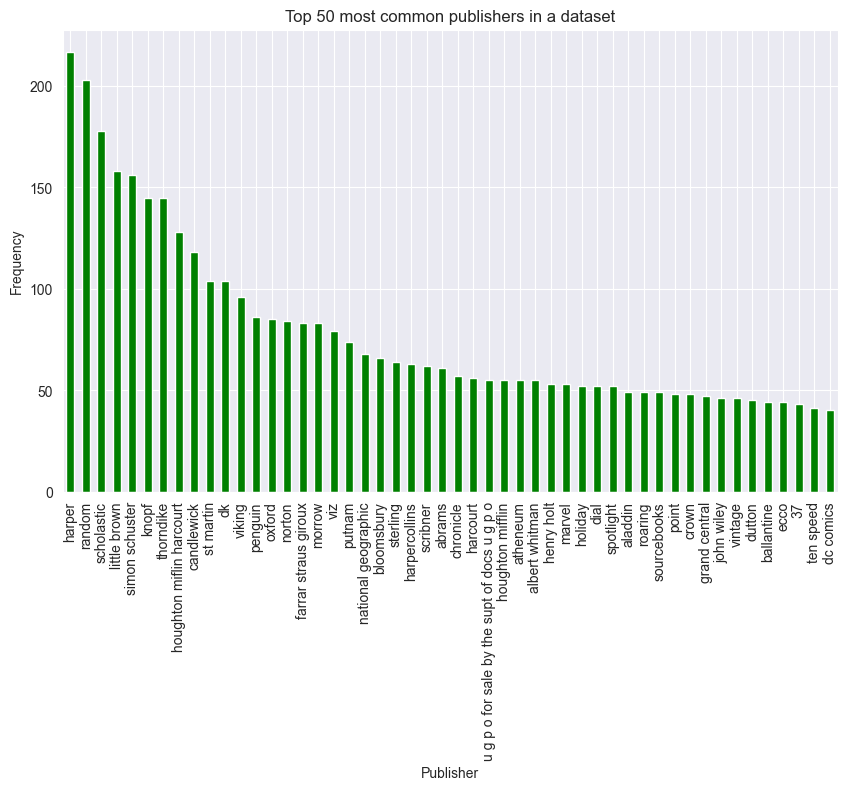

In [36]:
publisher_counts = books['Publisher'].value_counts()
plt.figure(figsize=(10, 6))
publisher_counts.head(50).plot(kind='bar', color='green')
plt.title('Top 50 most common publishers in a dataset')
plt.xlabel('Publisher')
plt.ylabel('Frequency')
plt.show()

#### Ім'я автора

Наступна очистка, яку необхідно здійснити, це назви книг та імена авторів. В обраній базі даних ім'я автора книги зазначене в стовпчику 'Author' в порядку прізвище та ім'я через кому, при чому, в більшості записів для книги вказаний лише один автор. Однак, якщо розглянути стовпчик 'Title' в якому зазначена назва книги, легко побачити, що крім назви після слешу '/' у стовпчику також вказана додаткова інформація про книгу. Додаткова інформація містить список авторів і/або під чиєю редакцією випущена книга і/або автора ілюстрацій etc. Крім цього, сам стовпчик з іменами авторів дещо забруднений. Зокрема для частини книг автори не вказані, або, крім імен, додані числа, найімовірніше, роки життя. Питання того, чи допомагає додавання років життя авторів для даної бази з, наприклад, розрізненням кількох авторів з однаковим іменем, може бути важливим і є дискусійним. Проте, для даної вибірки, за попередніми спостереженнями, така проблема не стоїть, тому всі роки з імен авторів при очищенні слід видаляти.

Для того, щоб якнайточніше відобразити авторів книги не звертаючись до зовнішніх джерел, необхідно паралельно з очищенням даних про авторів, здійснювати очистку даних про назву книги, виділяючи додаткову інформацію зі стовпчика назви та порівнюючи із наявними даними про автора зі стовпчика авторів.

In [37]:
titles_and_authors = pd.DataFrame()
titles_and_authors[['Title', 'Author']] = books[['Title', 'Author']]
titles_and_authors

,Title,Author
0,Franklin and Luna and the book of fairy tales ...,"Campbell, Jen"
1,Holiday dinners with Bradley Ogden : 150 festi...,"Ogden, Bradley"
2,"Cuzco, Machu Picchu & the Inca heartland / Rob...","Kunstaetter, Robert"
3,Sleeping Beauty / retold by Cynthia Rylant ; p...,"Rylant, Cynthia"
4,How to escape from a leper colony : a novella ...,"Yanique, Tiphanie"
...,...,...
10244,Lover reborn / J.R. Ward.,"Ward, J. R., 1969-"
10245,Experimental drawing / Robert Kaupelis.,"Kaupelis, Robert"
10246,The bad guys in Alien vs. Bad Guys / Aaron Bla...,"Blabey, Aaron"
10247,English for everyone. Course book. Level 3 int...,"Johnson, Gill, 1964-"


Розділимо стовпчик 'Title' на назву та підназву для порівняння списку авторів з підназви із вказаними в базі даних авторами.

In [38]:
titles_and_authors[['TitleMain', 'Subtitle']] = titles_and_authors['Title'].str.split('/', n=1, expand=True)
titles_and_authors

,Title,Author,TitleMain,Subtitle
0,Franklin and Luna and the book of fairy tales ...,"Campbell, Jen",Franklin and Luna and the book of fairy tales,"Jen Campbell, Katie Harnett."
1,Holiday dinners with Bradley Ogden : 150 festi...,"Ogden, Bradley",Holiday dinners with Bradley Ogden : 150 festi...,Bradley Ogden with Lydia Scott.
2,"Cuzco, Machu Picchu & the Inca heartland / Rob...","Kunstaetter, Robert","Cuzco, Machu Picchu & the Inca heartland",Robert & Daisy Kunstaetter.
3,Sleeping Beauty / retold by Cynthia Rylant ; p...,"Rylant, Cynthia",Sleeping Beauty,retold by Cynthia Rylant ; pictures by Erin M...
4,How to escape from a leper colony : a novella ...,"Yanique, Tiphanie",How to escape from a leper colony : a novella ...,Tiphanie Yanique.
...,...,...,...,...
10244,Lover reborn / J.R. Ward.,"Ward, J. R., 1969-",Lover reborn,J.R. Ward.
10245,Experimental drawing / Robert Kaupelis.,"Kaupelis, Robert",Experimental drawing,Robert Kaupelis.
10246,The bad guys in Alien vs. Bad Guys / Aaron Bla...,"Blabey, Aaron",The bad guys in Alien vs. Bad Guys,Aaron Blabey.
10247,English for everyone. Course book. Level 3 int...,"Johnson, Gill, 1964-",English for everyone. Course book. Level 3 int...,"[author, Gill Johnson."


#### Видобування імені автора з додаткової інформації про книгу

Легко бачити, що для книг, в яких відсутнє значення в стовпчику 'Author' може бути зазначений автор у підназві. Дослідимо це явище, виділивши підмножину книг, в яких не зазначений автор.

In [39]:
rows_without_author = titles_and_authors[titles_and_authors['Author'].isna()]
rows_without_author

,Title,Author,TitleMain,Subtitle
5,Crucial conversations : tools for talking when...,NaN,Crucial conversations : tools for talking when...,Kerry Patterson ... [and others].
9,"Be here now, remember.",NaN,"Be here now, remember.",None
23,"A very merry temptation / Kimberly Kaye Terry,...",NaN,A very merry temptation,"Kimberly Kaye Terry, Pamela Yaye, Farrah Rochon."
65,Crossing the frontier : photographs of the dev...,NaN,Crossing the frontier : photographs of the dev...,Sandra S. Phillips ... [and others].
78,What's wrong with mindfulness (and what isn't)...,NaN,What's wrong with mindfulness (and what isn't)...,edited by Robert Meikyo Rosenbaum and Barry M...
...,...,...,...,...
10089,Contemporary American religion / Wade Clark Ro...,NaN,Contemporary American religion,"Wade Clark Roof, editor in chief."
10102,¡Manteca!: : an anthology of Afro-Latin@ poets...,NaN,¡Manteca!: : an anthology of Afro-Latin@ poets,edited by Melissa Castillo-Garsow.
10115,Here comes Mother Goose / edited by Iona Opie ...,NaN,Here comes Mother Goose,edited by Iona Opie ; illustrated by Rosemary...
10175,The best American comics 2009 / edited and wit...,NaN,The best American comics 2009,edited and with an introduction by Charles Bu...


In [40]:
rows_without_author['Subtitle'].isna().sum()

117

Відносно всієї вибірки, приблизно в 5% записів про книг не містять інформації про автора. В підмножині книг, для яких відсутній автор, приблизно 20% записів про книги, які не мають зазначеного автора, також не мають жодної додаткової інформації. Розглянувши дану підмножину книг, можна виділити такі категорії:
1. Книги з великою кількістю співавторів, наприклад, збірники есе на певну тему.
2. Книги видані організацією, де авторство належить не одній особі, а всій організації.
3. Довідкова література, підручники та каталоги, де за відсутності автора в додатковій інформації вказується редактор.
4. Релігійні тексти, де вказується лише перекладач.
5. Фольклор, де вказується укладач, перекладач або редактор.
6. Дитячі книги, де в додатковій інформації вказаний лише ілюстратор.
7. Книги, де автор чітко зазначений в додатковій інформації, але не внесений в стовпчик авторів через людську помилку.

Якщо ми прагнемо до максимальної чистоти та густини даних без звертання до зовнішніх джерел, найпростішим виходом буде викинути записи з відсутніми даними, оскільки ця проблема вражає відносно малу частину вибірки. Проте, якщо ми в результаті захочемо підтягувати більше записів, особливо якщо нас цікавитиме в межах аналізу якась із виділених категорій, дана проблема може постати більш гостро. Обробкою підзаголовка частину з цих даних можна врятувати.

Визначимо набір логічних правил, за якими будемо виділяти автора з довідкової інформації:
1. Автором може бути тільки людина. Тобто, в книг за авторством організацій без додаткової інформації автор буде відсутній.
2. У вибірку буде внесений тільки один автор на книгу. Якщо в додатковій інформації перелічено кілька авторів, буде обраний перший в списку.
3. За відсутності автора, автором можна вносити редактора, ілюстратора або перекладача.
4. Припускаємо, що особи, що долучилися до створення книги вказані в порядку спадання їх внеску, тому перша людина в списку імен в додатковій інформації (підзаголовоку) вважається головним автором.

Враховуючи ці правила, можна оглянути підмножину записів з відсутніми авторами і, за допомогою бібліотеки spacy, знайти авторів в підзаголовках.

In [41]:
import spacy

In [42]:
nlp = spacy.load('en_core_web_sm')

In [43]:
def extract_names(text):
    if pd.notna(text):
        doc = nlp(text)
        names = [ent.text for ent in doc.ents if ent.label_ == 'PERSON']
        return names
    else:
        return np.nan

In [44]:
titles_and_authors['Subtitle'] = titles_and_authors['Subtitle'].astype('str')
titles_and_authors['SubtitleAuth'] = titles_and_authors.loc[titles_and_authors['Author'].isna(), 'Subtitle'].apply(extract_names)
titles_and_authors

,Title,Author,TitleMain,Subtitle,SubtitleAuth
0,Franklin and Luna and the book of fairy tales ...,"Campbell, Jen",Franklin and Luna and the book of fairy tales,"Jen Campbell, Katie Harnett.",NaN
1,Holiday dinners with Bradley Ogden : 150 festi...,"Ogden, Bradley",Holiday dinners with Bradley Ogden : 150 festi...,Bradley Ogden with Lydia Scott.,NaN
2,"Cuzco, Machu Picchu & the Inca heartland / Rob...","Kunstaetter, Robert","Cuzco, Machu Picchu & the Inca heartland",Robert & Daisy Kunstaetter.,NaN
3,Sleeping Beauty / retold by Cynthia Rylant ; p...,"Rylant, Cynthia",Sleeping Beauty,retold by Cynthia Rylant ; pictures by Erin M...,NaN
4,How to escape from a leper colony : a novella ...,"Yanique, Tiphanie",How to escape from a leper colony : a novella ...,Tiphanie Yanique.,NaN
...,...,...,...,...,...
10244,Lover reborn / J.R. Ward.,"Ward, J. R., 1969-",Lover reborn,J.R. Ward.,NaN
10245,Experimental drawing / Robert Kaupelis.,"Kaupelis, Robert",Experimental drawing,Robert Kaupelis.,NaN
10246,The bad guys in Alien vs. Bad Guys / Aaron Bla...,"Blabey, Aaron",The bad guys in Alien vs. Bad Guys,Aaron Blabey.,NaN
10247,English for everyone. Course book. Level 3 int...,"Johnson, Gill, 1964-",English for everyone. Course book. Level 3 int...,"[author, Gill Johnson.",NaN


При перегляді результатів витягування повних імен із підзаголовку, можна зробити висновок, що для більшості з них спочатку йде ім'я, опціонально друге (так зване середнє) ім'я, прізвище вкінці. Натомість, для стовпчика 'Author' спочатку зазначене прізвище, а потім ім'я. Необхідно звести все до єдиного формату. В межах даної роботи, оскільки не розглядається потенційний аналіз книг за певними характеристиками імені автора, повне ім'я можна вказати не розділяючи на частини і нормалізувати відображення імені буде зручніше у форматі "ім'я прізвище" (на противагу формату "прізвище ім'я").

In [45]:
def strip_everything(dataframe, column_name):
    pattern = r'^[^A-Za-z\.]+|[^A-Za-z\.]+$|\(.*$'
    dataframe[column_name] = dataframe[column_name].str.replace(pattern, '', regex=True)
    return dataframe

In [46]:
titles_and_authors['AuthorClean'] = titles_and_authors['Author'].astype('string')
titles_and_authors = strip_everything(titles_and_authors, 'AuthorClean')
titles_and_authors

,Title,Author,TitleMain,Subtitle,SubtitleAuth,AuthorClean
0,Franklin and Luna and the book of fairy tales ...,"Campbell, Jen",Franklin and Luna and the book of fairy tales,"Jen Campbell, Katie Harnett.",NaN,"Campbell, Jen"
1,Holiday dinners with Bradley Ogden : 150 festi...,"Ogden, Bradley",Holiday dinners with Bradley Ogden : 150 festi...,Bradley Ogden with Lydia Scott.,NaN,"Ogden, Bradley"
2,"Cuzco, Machu Picchu & the Inca heartland / Rob...","Kunstaetter, Robert","Cuzco, Machu Picchu & the Inca heartland",Robert & Daisy Kunstaetter.,NaN,"Kunstaetter, Robert"
3,Sleeping Beauty / retold by Cynthia Rylant ; p...,"Rylant, Cynthia",Sleeping Beauty,retold by Cynthia Rylant ; pictures by Erin M...,NaN,"Rylant, Cynthia"
4,How to escape from a leper colony : a novella ...,"Yanique, Tiphanie",How to escape from a leper colony : a novella ...,Tiphanie Yanique.,NaN,"Yanique, Tiphanie"
...,...,...,...,...,...,...
10244,Lover reborn / J.R. Ward.,"Ward, J. R., 1969-",Lover reborn,J.R. Ward.,NaN,"Ward, J. R."
10245,Experimental drawing / Robert Kaupelis.,"Kaupelis, Robert",Experimental drawing,Robert Kaupelis.,NaN,"Kaupelis, Robert"
10246,The bad guys in Alien vs. Bad Guys / Aaron Bla...,"Blabey, Aaron",The bad guys in Alien vs. Bad Guys,Aaron Blabey.,NaN,"Blabey, Aaron"
10247,English for everyone. Course book. Level 3 int...,"Johnson, Gill, 1964-",English for everyone. Course book. Level 3 int...,"[author, Gill Johnson.",NaN,"Johnson, Gill"


In [47]:
titles_and_authors[['AuthSurname', 'AuthName']] = titles_and_authors['AuthorClean'].str.split(', ', n=1, expand=True)
titles_and_authors

,Title,Author,TitleMain,Subtitle,SubtitleAuth,AuthorClean,AuthSurname,AuthName
0,Franklin and Luna and the book of fairy tales ...,"Campbell, Jen",Franklin and Luna and the book of fairy tales,"Jen Campbell, Katie Harnett.",NaN,"Campbell, Jen",Campbell,Jen
1,Holiday dinners with Bradley Ogden : 150 festi...,"Ogden, Bradley",Holiday dinners with Bradley Ogden : 150 festi...,Bradley Ogden with Lydia Scott.,NaN,"Ogden, Bradley",Ogden,Bradley
2,"Cuzco, Machu Picchu & the Inca heartland / Rob...","Kunstaetter, Robert","Cuzco, Machu Picchu & the Inca heartland",Robert & Daisy Kunstaetter.,NaN,"Kunstaetter, Robert",Kunstaetter,Robert
3,Sleeping Beauty / retold by Cynthia Rylant ; p...,"Rylant, Cynthia",Sleeping Beauty,retold by Cynthia Rylant ; pictures by Erin M...,NaN,"Rylant, Cynthia",Rylant,Cynthia
4,How to escape from a leper colony : a novella ...,"Yanique, Tiphanie",How to escape from a leper colony : a novella ...,Tiphanie Yanique.,NaN,"Yanique, Tiphanie",Yanique,Tiphanie
...,...,...,...,...,...,...,...,...
10244,Lover reborn / J.R. Ward.,"Ward, J. R., 1969-",Lover reborn,J.R. Ward.,NaN,"Ward, J. R.",Ward,J. R.
10245,Experimental drawing / Robert Kaupelis.,"Kaupelis, Robert",Experimental drawing,Robert Kaupelis.,NaN,"Kaupelis, Robert",Kaupelis,Robert
10246,The bad guys in Alien vs. Bad Guys / Aaron Bla...,"Blabey, Aaron",The bad guys in Alien vs. Bad Guys,Aaron Blabey.,NaN,"Blabey, Aaron",Blabey,Aaron
10247,English for everyone. Course book. Level 3 int...,"Johnson, Gill, 1964-",English for everyone. Course book. Level 3 int...,"[author, Gill Johnson.",NaN,"Johnson, Gill",Johnson,Gill


In [48]:
titles_and_authors['AuthName'] = titles_and_authors['AuthName'].str.replace(r',.*$', '', regex=True)
titles_and_authors

,Title,Author,TitleMain,Subtitle,SubtitleAuth,AuthorClean,AuthSurname,AuthName
0,Franklin and Luna and the book of fairy tales ...,"Campbell, Jen",Franklin and Luna and the book of fairy tales,"Jen Campbell, Katie Harnett.",NaN,"Campbell, Jen",Campbell,Jen
1,Holiday dinners with Bradley Ogden : 150 festi...,"Ogden, Bradley",Holiday dinners with Bradley Ogden : 150 festi...,Bradley Ogden with Lydia Scott.,NaN,"Ogden, Bradley",Ogden,Bradley
2,"Cuzco, Machu Picchu & the Inca heartland / Rob...","Kunstaetter, Robert","Cuzco, Machu Picchu & the Inca heartland",Robert & Daisy Kunstaetter.,NaN,"Kunstaetter, Robert",Kunstaetter,Robert
3,Sleeping Beauty / retold by Cynthia Rylant ; p...,"Rylant, Cynthia",Sleeping Beauty,retold by Cynthia Rylant ; pictures by Erin M...,NaN,"Rylant, Cynthia",Rylant,Cynthia
4,How to escape from a leper colony : a novella ...,"Yanique, Tiphanie",How to escape from a leper colony : a novella ...,Tiphanie Yanique.,NaN,"Yanique, Tiphanie",Yanique,Tiphanie
...,...,...,...,...,...,...,...,...
10244,Lover reborn / J.R. Ward.,"Ward, J. R., 1969-",Lover reborn,J.R. Ward.,NaN,"Ward, J. R.",Ward,J. R.
10245,Experimental drawing / Robert Kaupelis.,"Kaupelis, Robert",Experimental drawing,Robert Kaupelis.,NaN,"Kaupelis, Robert",Kaupelis,Robert
10246,The bad guys in Alien vs. Bad Guys / Aaron Bla...,"Blabey, Aaron",The bad guys in Alien vs. Bad Guys,Aaron Blabey.,NaN,"Blabey, Aaron",Blabey,Aaron
10247,English for everyone. Course book. Level 3 int...,"Johnson, Gill, 1964-",English for everyone. Course book. Level 3 int...,"[author, Gill Johnson.",NaN,"Johnson, Gill",Johnson,Gill


In [49]:
def get_first_author(lst):
    return lst[0] if (lst and isinstance(lst, list)) else np.nan

In [50]:
titles_and_authors['AuthorFinal'] = None
titles_and_authors['AuthorFinal'] = titles_and_authors['AuthorFinal'].fillna(titles_and_authors['SubtitleAuth'].apply(get_first_author))
titles_and_authors

,Title,Author,TitleMain,Subtitle,SubtitleAuth,AuthorClean,AuthSurname,AuthName,AuthorFinal
0,Franklin and Luna and the book of fairy tales ...,"Campbell, Jen",Franklin and Luna and the book of fairy tales,"Jen Campbell, Katie Harnett.",NaN,"Campbell, Jen",Campbell,Jen,NaN
1,Holiday dinners with Bradley Ogden : 150 festi...,"Ogden, Bradley",Holiday dinners with Bradley Ogden : 150 festi...,Bradley Ogden with Lydia Scott.,NaN,"Ogden, Bradley",Ogden,Bradley,NaN
2,"Cuzco, Machu Picchu & the Inca heartland / Rob...","Kunstaetter, Robert","Cuzco, Machu Picchu & the Inca heartland",Robert & Daisy Kunstaetter.,NaN,"Kunstaetter, Robert",Kunstaetter,Robert,NaN
3,Sleeping Beauty / retold by Cynthia Rylant ; p...,"Rylant, Cynthia",Sleeping Beauty,retold by Cynthia Rylant ; pictures by Erin M...,NaN,"Rylant, Cynthia",Rylant,Cynthia,NaN
4,How to escape from a leper colony : a novella ...,"Yanique, Tiphanie",How to escape from a leper colony : a novella ...,Tiphanie Yanique.,NaN,"Yanique, Tiphanie",Yanique,Tiphanie,NaN
...,...,...,...,...,...,...,...,...,...
10244,Lover reborn / J.R. Ward.,"Ward, J. R., 1969-",Lover reborn,J.R. Ward.,NaN,"Ward, J. R.",Ward,J. R.,NaN
10245,Experimental drawing / Robert Kaupelis.,"Kaupelis, Robert",Experimental drawing,Robert Kaupelis.,NaN,"Kaupelis, Robert",Kaupelis,Robert,NaN
10246,The bad guys in Alien vs. Bad Guys / Aaron Bla...,"Blabey, Aaron",The bad guys in Alien vs. Bad Guys,Aaron Blabey.,NaN,"Blabey, Aaron",Blabey,Aaron,NaN
10247,English for everyone. Course book. Level 3 int...,"Johnson, Gill, 1964-",English for everyone. Course book. Level 3 int...,"[author, Gill Johnson.",NaN,"Johnson, Gill",Johnson,Gill,NaN


In [51]:
titles_and_authors['AuthorFinal'] = titles_and_authors['AuthorFinal'].fillna(titles_and_authors['AuthName'] + ' ' + titles_and_authors['AuthSurname'])
titles_and_authors

,Title,Author,TitleMain,Subtitle,SubtitleAuth,AuthorClean,AuthSurname,AuthName,AuthorFinal
0,Franklin and Luna and the book of fairy tales ...,"Campbell, Jen",Franklin and Luna and the book of fairy tales,"Jen Campbell, Katie Harnett.",NaN,"Campbell, Jen",Campbell,Jen,Jen Campbell
1,Holiday dinners with Bradley Ogden : 150 festi...,"Ogden, Bradley",Holiday dinners with Bradley Ogden : 150 festi...,Bradley Ogden with Lydia Scott.,NaN,"Ogden, Bradley",Ogden,Bradley,Bradley Ogden
2,"Cuzco, Machu Picchu & the Inca heartland / Rob...","Kunstaetter, Robert","Cuzco, Machu Picchu & the Inca heartland",Robert & Daisy Kunstaetter.,NaN,"Kunstaetter, Robert",Kunstaetter,Robert,Robert Kunstaetter
3,Sleeping Beauty / retold by Cynthia Rylant ; p...,"Rylant, Cynthia",Sleeping Beauty,retold by Cynthia Rylant ; pictures by Erin M...,NaN,"Rylant, Cynthia",Rylant,Cynthia,Cynthia Rylant
4,How to escape from a leper colony : a novella ...,"Yanique, Tiphanie",How to escape from a leper colony : a novella ...,Tiphanie Yanique.,NaN,"Yanique, Tiphanie",Yanique,Tiphanie,Tiphanie Yanique
...,...,...,...,...,...,...,...,...,...
10244,Lover reborn / J.R. Ward.,"Ward, J. R., 1969-",Lover reborn,J.R. Ward.,NaN,"Ward, J. R.",Ward,J. R.,J. R. Ward
10245,Experimental drawing / Robert Kaupelis.,"Kaupelis, Robert",Experimental drawing,Robert Kaupelis.,NaN,"Kaupelis, Robert",Kaupelis,Robert,Robert Kaupelis
10246,The bad guys in Alien vs. Bad Guys / Aaron Bla...,"Blabey, Aaron",The bad guys in Alien vs. Bad Guys,Aaron Blabey.,NaN,"Blabey, Aaron",Blabey,Aaron,Aaron Blabey
10247,English for everyone. Course book. Level 3 int...,"Johnson, Gill, 1964-",English for everyone. Course book. Level 3 int...,"[author, Gill Johnson.",NaN,"Johnson, Gill",Johnson,Gill,Gill Johnson


In [52]:
titles_and_authors['AuthorFinal'] = titles_and_authors['AuthorFinal'].str.replace(r' +', ' ', regex=True)
titles_and_authors['AuthorFinal'] = titles_and_authors['AuthorFinal'].str.strip()
titles_and_authors

,Title,Author,TitleMain,Subtitle,SubtitleAuth,AuthorClean,AuthSurname,AuthName,AuthorFinal
0,Franklin and Luna and the book of fairy tales ...,"Campbell, Jen",Franklin and Luna and the book of fairy tales,"Jen Campbell, Katie Harnett.",NaN,"Campbell, Jen",Campbell,Jen,Jen Campbell
1,Holiday dinners with Bradley Ogden : 150 festi...,"Ogden, Bradley",Holiday dinners with Bradley Ogden : 150 festi...,Bradley Ogden with Lydia Scott.,NaN,"Ogden, Bradley",Ogden,Bradley,Bradley Ogden
2,"Cuzco, Machu Picchu & the Inca heartland / Rob...","Kunstaetter, Robert","Cuzco, Machu Picchu & the Inca heartland",Robert & Daisy Kunstaetter.,NaN,"Kunstaetter, Robert",Kunstaetter,Robert,Robert Kunstaetter
3,Sleeping Beauty / retold by Cynthia Rylant ; p...,"Rylant, Cynthia",Sleeping Beauty,retold by Cynthia Rylant ; pictures by Erin M...,NaN,"Rylant, Cynthia",Rylant,Cynthia,Cynthia Rylant
4,How to escape from a leper colony : a novella ...,"Yanique, Tiphanie",How to escape from a leper colony : a novella ...,Tiphanie Yanique.,NaN,"Yanique, Tiphanie",Yanique,Tiphanie,Tiphanie Yanique
...,...,...,...,...,...,...,...,...,...
10244,Lover reborn / J.R. Ward.,"Ward, J. R., 1969-",Lover reborn,J.R. Ward.,NaN,"Ward, J. R.",Ward,J. R.,J. R. Ward
10245,Experimental drawing / Robert Kaupelis.,"Kaupelis, Robert",Experimental drawing,Robert Kaupelis.,NaN,"Kaupelis, Robert",Kaupelis,Robert,Robert Kaupelis
10246,The bad guys in Alien vs. Bad Guys / Aaron Bla...,"Blabey, Aaron",The bad guys in Alien vs. Bad Guys,Aaron Blabey.,NaN,"Blabey, Aaron",Blabey,Aaron,Aaron Blabey
10247,English for everyone. Course book. Level 3 int...,"Johnson, Gill, 1964-",English for everyone. Course book. Level 3 int...,"[author, Gill Johnson.",NaN,"Johnson, Gill",Johnson,Gill,Gill Johnson


#### Заголовок і підзаголовок книги

Таким чином дані про авторів можна вважати очищеними і їх пожна перенести в головний датафрейм. Проте, це не можна сказати про заголовки книг. Додаткова інформація, яку ми до цього взаємозамінно назвили то так, то підзаголовком, є саме лише додатковою інформацїєю. Якщо проаналізувати назви книг, які залишилися після її видалення, стане чітко зрозуміло, що у книг після двокрапки ":" вказаний саме підзаголовок у класичному розумінні. Задля очищення даних, заголовок і підзаголовок доречно розділити, та зберігати в окремих стовпчиках головного датафрейму.

In [53]:
titles_and_authors[['CleanTitle', 'CleanSubtitle']] = titles_and_authors['TitleMain'].str.split(' : ', n=1, expand=True)
titles_and_authors

,Title,Author,TitleMain,Subtitle,SubtitleAuth,AuthorClean,AuthSurname,AuthName,AuthorFinal,CleanTitle,CleanSubtitle
0,Franklin and Luna and the book of fairy tales ...,"Campbell, Jen",Franklin and Luna and the book of fairy tales,"Jen Campbell, Katie Harnett.",NaN,"Campbell, Jen",Campbell,Jen,Jen Campbell,Franklin and Luna and the book of fairy tales,None
1,Holiday dinners with Bradley Ogden : 150 festi...,"Ogden, Bradley",Holiday dinners with Bradley Ogden : 150 festi...,Bradley Ogden with Lydia Scott.,NaN,"Ogden, Bradley",Ogden,Bradley,Bradley Ogden,Holiday dinners with Bradley Ogden,150 festive recipes for bringing family & frie...
2,"Cuzco, Machu Picchu & the Inca heartland / Rob...","Kunstaetter, Robert","Cuzco, Machu Picchu & the Inca heartland",Robert & Daisy Kunstaetter.,NaN,"Kunstaetter, Robert",Kunstaetter,Robert,Robert Kunstaetter,"Cuzco, Machu Picchu & the Inca heartland",None
3,Sleeping Beauty / retold by Cynthia Rylant ; p...,"Rylant, Cynthia",Sleeping Beauty,retold by Cynthia Rylant ; pictures by Erin M...,NaN,"Rylant, Cynthia",Rylant,Cynthia,Cynthia Rylant,Sleeping Beauty,None
4,How to escape from a leper colony : a novella ...,"Yanique, Tiphanie",How to escape from a leper colony : a novella ...,Tiphanie Yanique.,NaN,"Yanique, Tiphanie",Yanique,Tiphanie,Tiphanie Yanique,How to escape from a leper colony,a novella and stories
...,...,...,...,...,...,...,...,...,...,...,...
10244,Lover reborn / J.R. Ward.,"Ward, J. R., 1969-",Lover reborn,J.R. Ward.,NaN,"Ward, J. R.",Ward,J. R.,J. R. Ward,Lover reborn,None
10245,Experimental drawing / Robert Kaupelis.,"Kaupelis, Robert",Experimental drawing,Robert Kaupelis.,NaN,"Kaupelis, Robert",Kaupelis,Robert,Robert Kaupelis,Experimental drawing,None
10246,The bad guys in Alien vs. Bad Guys / Aaron Bla...,"Blabey, Aaron",The bad guys in Alien vs. Bad Guys,Aaron Blabey.,NaN,"Blabey, Aaron",Blabey,Aaron,Aaron Blabey,The bad guys in Alien vs. Bad Guys,None
10247,English for everyone. Course book. Level 3 int...,"Johnson, Gill, 1964-",English for everyone. Course book. Level 3 int...,"[author, Gill Johnson.",NaN,"Johnson, Gill",Johnson,Gill,Gill Johnson,English for everyone. Course book. Level 3 int...,None


In [54]:
books.insert(2, 'AuthorCl', titles_and_authors['AuthorFinal'])
books.insert(2, 'Subtitle', titles_and_authors['CleanSubtitle'])
books.insert(2, 'TitleCl', titles_and_authors['CleanTitle'])
books

,BibNum,Title,TitleCl,Subtitle,AuthorCl,Author,ISBN10,ISBN13,PublicationYear,Publisher,Subjects,ItemType,ItemCollection,ItemLocation,ReportDate,ItemCount
0,3479509,Franklin and Luna and the book of fairy tales ...,Franklin and Luna and the book of fairy tales,None,Jen Campbell,"Campbell, Jen",0500651752,9780500651759,2019,thames hudson,"Dragons Juvenile fiction, Characters and chara...",jcbk,ncnew,net,03/01/2020,1
1,2737917,Holiday dinners with Bradley Ogden : 150 festi...,Holiday dinners with Bradley Ogden,150 festive recipes for bringing family & frie...,Bradley Ogden,"Ogden, Bradley",0762439157,9780762439157,2011,running,"Cooking, Holiday cooking",acbk,nanf,swt,12/01/2020,1
2,3359831,"Cuzco, Machu Picchu & the Inca heartland / Rob...","Cuzco, Machu Picchu & the Inca heartland",None,Robert Kunstaetter,"Kunstaetter, Robert",1911082256,9781911082255,2017,footprint,"Peru Guidebooks, Cuzco Peru Guidebooks, Machu ...",acbk,nanf,wts,03/01/2020,1
3,3298424,Sleeping Beauty / retold by Cynthia Rylant ; p...,Sleeping Beauty,None,Cynthia Rylant,"Rylant, Cynthia",1423121082,9781423121084,2015,disney hyperion,"Sleeping Beauty Tale Juvenile literature, Folk...",jcbk,ncfft,mag,11/01/2020,1
4,3203995,How to escape from a leper colony : a novella ...,How to escape from a leper colony,a novella and stories,Tiphanie Yanique,"Yanique, Tiphanie",155597550X,9781555975500,2010,graywolf,"United States Virgin Islands Fiction, Short st...",acbk,cafic,cen,05/01/2020,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10244,2760306,Lover reborn / J.R. Ward.,Lover reborn,None,J. R. Ward,"Ward, J. R., 1969-",0451235843,9780451235848,2012,new american library,"Vampires Fiction, Paranormal romance stories, ...",acbk,nafic,dlr,10/01/2020,1
10245,2724228,Experimental drawing / Robert Kaupelis.,Experimental drawing,None,Robert Kaupelis,"Kaupelis, Robert",0823016188,9780823016181,1980,watson guptill,"Drawing Study and teaching, Drawing Technique",acbk,nanf,rbe,09/01/2020,1
10246,3364815,The bad guys in Alien vs. Bad Guys / Aaron Bla...,The bad guys in Alien vs. Bad Guys,None,Aaron Blabey,"Blabey, Aaron",133818959X,9781338189599,2018,scholastic,"Extraterrestrial beings Juvenile fiction, Kidn...",jcbk,ncef,glk,10/01/2020,1
10247,3227571,English for everyone. Course book. Level 3 int...,English for everyone. Course book. Level 3 int...,None,Gill Johnson,"Johnson, Gill, 1964-",1465447636,9781465447630,2016,dk,"English language Self instruction, English lan...",bcbk,naesli,col,03/01/2020,1


In [55]:
books = books.drop('Title', axis=1)
books = books.drop('Author', axis=1)
books = books.rename(columns={'TitleCl' : 'Title', 'AuthorCl' : 'Author'})
books

,BibNum,Title,Subtitle,Author,ISBN10,ISBN13,PublicationYear,Publisher,Subjects,ItemType,ItemCollection,ItemLocation,ReportDate,ItemCount
0,3479509,Franklin and Luna and the book of fairy tales,None,Jen Campbell,0500651752,9780500651759,2019,thames hudson,"Dragons Juvenile fiction, Characters and chara...",jcbk,ncnew,net,03/01/2020,1
1,2737917,Holiday dinners with Bradley Ogden,150 festive recipes for bringing family & frie...,Bradley Ogden,0762439157,9780762439157,2011,running,"Cooking, Holiday cooking",acbk,nanf,swt,12/01/2020,1
2,3359831,"Cuzco, Machu Picchu & the Inca heartland",None,Robert Kunstaetter,1911082256,9781911082255,2017,footprint,"Peru Guidebooks, Cuzco Peru Guidebooks, Machu ...",acbk,nanf,wts,03/01/2020,1
3,3298424,Sleeping Beauty,None,Cynthia Rylant,1423121082,9781423121084,2015,disney hyperion,"Sleeping Beauty Tale Juvenile literature, Folk...",jcbk,ncfft,mag,11/01/2020,1
4,3203995,How to escape from a leper colony,a novella and stories,Tiphanie Yanique,155597550X,9781555975500,2010,graywolf,"United States Virgin Islands Fiction, Short st...",acbk,cafic,cen,05/01/2020,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10244,2760306,Lover reborn,None,J. R. Ward,0451235843,9780451235848,2012,new american library,"Vampires Fiction, Paranormal romance stories, ...",acbk,nafic,dlr,10/01/2020,1
10245,2724228,Experimental drawing,None,Robert Kaupelis,0823016188,9780823016181,1980,watson guptill,"Drawing Study and teaching, Drawing Technique",acbk,nanf,rbe,09/01/2020,1
10246,3364815,The bad guys in Alien vs. Bad Guys,None,Aaron Blabey,133818959X,9781338189599,2018,scholastic,"Extraterrestrial beings Juvenile fiction, Kidn...",jcbk,ncef,glk,10/01/2020,1
10247,3227571,English for everyone. Course book. Level 3 int...,None,Gill Johnson,1465447636,9781465447630,2016,dk,"English language Self instruction, English lan...",bcbk,naesli,col,03/01/2020,1


#### Обробка тем книги

Для обраного набору даних найцікавішим елементом був стовпчик 'Subjects', що містить теми, які зачіпаються в кожній книзі. Очікувалося, що, в межах бази даних бібліотеки, такі описи тем будуть значно більш стандартизовані, ніж при використанні даних із сайтів продажу та рекомендаційних сервісів книг. Проте, можна побачити, що, хоча між даними темами часто трапляються спільні слова і вони значною мірою перетинаються, їхня ортографічна близькість не означає належність одній сутності, тому, виділення сутностей методом, який ми використали для видавництв, принесе більше шкоди, ніж користі. [ Також, через їхню кількість і різноманіття вони погано підходять як категорії для класифікації в сирому вигляді. Таким чином, було прийняте рішення за потреби використовувати їх як аналог опису. ? ] Нижче наведений невеликий огляд даного стовпчика.

In [56]:
books['Subjects'] = books['Subjects'].astype('string')

In [57]:
all_subjects = []
def find_all_subjects(text):
    if pd.notna(text):
        for t in text.split(', '):
            all_subjects.append(t.strip())

In [58]:
books['Subjects'].apply(find_all_subjects)
all_subjects

['Dragons Juvenile fiction',
 'Characters and characteristics in literature Juvenile fiction',
 'Surprise birthday parties Juvenile fiction',
 'Books and reading Juvenile fiction',
 'Cooking',
 'Holiday cooking',
 'Peru Guidebooks',
 'Cuzco Peru Guidebooks',
 'Machu Picchu Site Peru Guidebooks',
 'Sleeping Beauty Tale Juvenile literature',
 'Folklore Germany Juvenile literature',
 'Fairy tales Adaptations Juvenile literature',
 'Fairy tales',
 'Folklore',
 'United States Virgin Islands Fiction',
 'Short stories',
 'Interpersonal communication',
 'Interpersonal relations',
 'Mental illness',
 'Psychology Pathological',
 'Coaching Athletics',
 'Basketball coaches United States',
 'Football coaches United States',
 'Aquaman Fictitious character Comic books strips etc',
 'Superheroes Comic books strips etc',
 'Superhero comics',
 'Comics Graphic works',
 'Graphic novels',
 'Ram Dass',
 'Spiritual life',
 'New Age movement',
 'Lynley Thomas Fiction',
 'Havers Barbara Fictitious character Fi

In [59]:
subjects_df = pd.DataFrame(all_subjects, columns=['Subject'])
subjects_df

,Subject
0,Dragons Juvenile fiction
1,Characters and characteristics in literature J...
2,Surprise birthday parties Juvenile fiction
3,Books and reading Juvenile fiction
4,Cooking
...,...
41273,English language Programmed instruction
41274,Textbooks
41275,Jazz History and criticism
41276,Music and literature History 20th century


In [60]:
subjects_df.value_counts()

Subject                                   
Graphic novels                                524
Picture books                                 363
Detective and mystery fiction                 362
Historical fiction                            274
Friendship Juvenile fiction                   256
                                             ... 
Gods Greek Juvenile fiction                     1
Gods Greek Miscellanea Juvenile literature      1
Gods Shinto Comic books strips etc              1
Gogh Vincent van 1853 1890                      1
™mer L–tfi Pasa 1806 1871 Fiction               1
Name: count, Length: 19737, dtype: int64

In [61]:
subjects_df.value_counts().value_counts()

count
1     15385
2      2201
3       761
4       381
5       213
      ...  
92        1
94        1
96        1
99        1
53        1
Name: count, Length: 94, dtype: int64

In [62]:
subjects_df['Subject'].unique()

array(['Dragons Juvenile fiction',
       'Characters and characteristics in literature Juvenile fiction',
       'Surprise birthday parties Juvenile fiction', ...,
       'Drawing Study and teaching',
       'Music and literature History 20th century',
       'Art and music History 20th century'], dtype=object)

#### Аналіз колекцій книг у вибірці

Водночас, стовпчик 'ItemCollection' може служити чудовою ціллю для класифікації, оскільки:
1. Він чітко визначений для кожної книги за її цільовою аудиторією та тематикою.
2. Кожна книга може мати тільки одну колекцію, якій вона належить.
3. Автоматизація процесу віднесення книги до певної колекції покращує процеси прийому книг в бібліотеці на облік і, таким чином, приносить суспільну користь та може бути предметом для подальших досліджень.

Здійснимо аналіз вибірки за стовпчиком колекції книги.

In [63]:
books['ItemCollection'] = books['ItemCollection'].astype('string')
books['ItemCollection'] = books['ItemCollection'].str.strip()
books['ItemCollection'].value_counts()

ItemCollection
nanf       1764
canf       1613
ncpic       852
nafic       697
ncnf        513
           ... 
casbr         1
cash          1
naaanew       1
cs9rf         1
nclp          1
Name: count, Length: 122, dtype: Int64

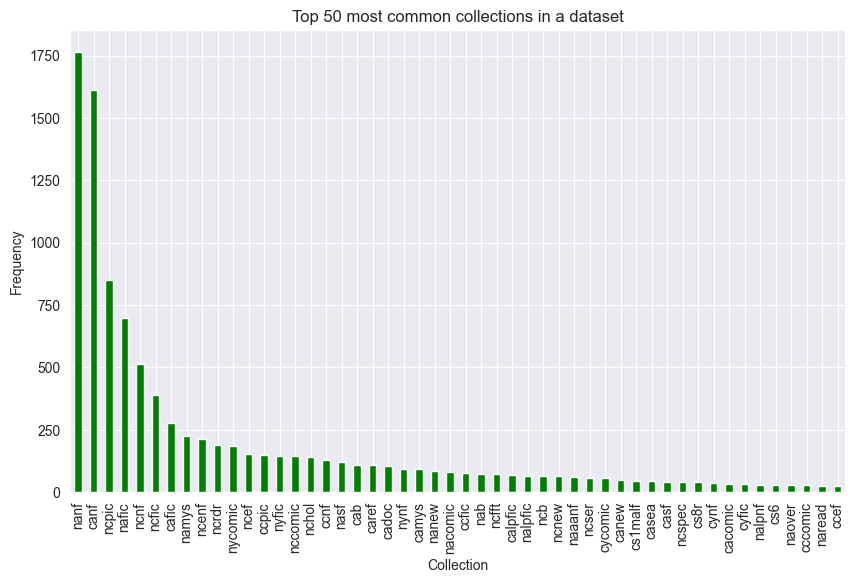

In [64]:
collection_counts = books['ItemCollection'].value_counts()
plt.figure(figsize=(10, 6))
collection_counts.head(50).plot(kind='bar', color='green')
plt.title('Top 50 most common collections in a dataset')
plt.xlabel('Collection')
plt.ylabel('Frequency')
plt.show()

### Отримання додаткової інформації із зовнішніх джерел

Бачимо, що вибірка не дуже добре збалансована стосовно колекцій, які в неї входять і це буде потрібно врахувати при здійсненні класифікації. Якщо виділити класифікацію за колекціями та кластеризацію як основні цілі аналізу даних в цій вибірці, ймовірно, з більшою кількістю числових показників ми могли б досягнути більшої точності. Такими числовими показниками можуть стати, наприклад, кількість сторінок у книзі або навіть оцінка книги на певному сервісі. Ми можемо видобути такі показники з інших баз даних або відкритих джерел здійснюючи пошук за ISBN.

В ролі зовнішнього джерела даних використаний набір даних з сайту goodreads, який можна знайти за посиланням https://www.kaggle.com/datasets/bahramjannesarr/goodreads-book-datasets-10m . З нього ми збиратимемо лише найцікавіші для нас дані - ISBN, кількість сторінок і рейтинг. Дані були розбиті на 23 файли csv, востаннє оновлювались 3 роки тому. Свіжі датасети з goodreads зараз загалом досить складно знайти, оскільки дана організація припинила надавати API ключі з 2020 року і вже тривалий час збільшує кількість перешкод на шляху до доступу до своїх даних, що, в тому числі, проявляється у перешкодах парсингу вказаного сайту. Враховуючи те, що більшість даних з бібліотечної вибірки, мають дату надходження примірників 2020 року, даний датасет з goodreads містить найактуальніші дані на момент отримання даних книг бібліотечним фондом.

In [65]:
def get_additional_info_goodreads(csv_name):
    gr_info = pd.DataFrame()
    columns_to_extract = {
        'ISBN' : str,
        'pagesNumber' : int,
        'Rating' : float
    }
    gr_info = pd.read_csv(csv_name, usecols=columns_to_extract.keys(), dtype=columns_to_extract)
    return gr_info

In [66]:
def get_additional_info_goodreads1(csv_name):
    gr_info = pd.DataFrame()
    columns_to_extract = {
        'ISBN' : str,
        'PagesNumber' : int,
        'Rating' : float
    }
    gr_info = pd.read_csv(csv_name, usecols=columns_to_extract.keys(), dtype=columns_to_extract)
    return gr_info

In [67]:
goodreads_books_add = pd.DataFrame()

In [68]:
goodreads_datasets = ['book1-100k.csv', 'book100k-200k.csv', 'book200k-300k.csv', 'book300k-400k.csv', 'book400k-500k.csv', 'book500k-600k.csv', 'book600k-700k.csv', 'book700k-800k.csv', 'book800k-900k.csv', 'book900k-1000k.csv', 'book1000k-1100k.csv', 'book1100k-1200k.csv', 'book1200k-1300k.csv', 'book1300k-1400k.csv', 'book1400k-1500k.csv', 'book1500k-1600k.csv', 'book1600k-1700k.csv', 'book1700k-1800k.csv']
goodreads_datasets_other =['book1800k-1900k.csv', 'book1900k-2000k.csv', 'book2000k-3000k.csv', 'book3000k-4000k.csv', 'book4000k-5000k.csv']

In [69]:
for b in goodreads_datasets:
    goodreads_books_add = pd.concat([goodreads_books_add, get_additional_info_goodreads(b)], axis=0)

In [70]:
goodreads_books_add = goodreads_books_add.rename(columns={'pagesNumber' : 'PagesNumber'})

In [71]:
for b in goodreads_datasets_other:
    goodreads_books_add = pd.concat([goodreads_books_add, get_additional_info_goodreads1(b)], axis=0)

In [72]:
goodreads_books_add

,PagesNumber,Rating,ISBN
0,652,4.57,NaN
1,870,4.50,0439358078
2,309,4.47,NaN
3,352,4.42,0439554896
4,435,4.57,043965548X
...,...,...,...
280251,90,0.00,187782500X
280252,439,3.00,0256218943
280253,120,0.00,0955823811
280254,232,3.80,0955823803


In [73]:
goodreads_books_add['ISBN'] = goodreads_books_add['ISBN'].astype('string')
goodreads_books_add_clean = goodreads_books_add.dropna(subset='ISBN')
goodreads_books_add_clean

,PagesNumber,Rating,ISBN
1,870,4.50,0439358078
3,352,4.42,0439554896
4,435,4.57,043965548X
6,2690,4.78,0439682584
7,152,3.79,0976540606
...,...,...,...
280251,90,0.00,187782500X
280252,439,3.00,0256218943
280253,120,0.00,0955823811
280254,232,3.80,0955823803


In [74]:
goodreads_books_add_clean.to_csv('goodreads_data.csv', index=False)

In [75]:
goodreads_from_csv = pd.read_csv('goodreads_data.csv')
goodreads_from_csv['ISBN'] = goodreads_from_csv['ISBN'].astype('string')
goodreads_from_csv

,PagesNumber,Rating,ISBN
0,870,4.50,0439358078
1,352,4.42,0439554896
2,435,4.57,043965548X
3,2690,4.78,0439682584
4,152,3.79,0976540606
...,...,...,...
1844382,90,0.00,187782500X
1844383,439,3.00,0256218943
1844384,120,0.00,0955823811
1844385,232,3.80,0955823803


In [76]:
merged_books = pd.DataFrame()
books['ISBN10'] = books['ISBN10'].astype('string')
books['ISBN13'] = books['ISBN13'].astype('string')
merged_books = pd.merge(books, goodreads_from_csv, left_on='ISBN10', right_on='ISBN', how='left')
merged_books

,BibNum,Title,Subtitle,Author,ISBN10,ISBN13,PublicationYear,Publisher,Subjects,ItemType,ItemCollection,ItemLocation,ReportDate,ItemCount,PagesNumber,Rating,ISBN
0,3479509,Franklin and Luna and the book of fairy tales,None,Jen Campbell,0500651752,9780500651759,2019,thames hudson,"Dragons Juvenile fiction, Characters and chara...",jcbk,ncnew,net,03/01/2020,1,NaN,NaN,<NA>
1,2737917,Holiday dinners with Bradley Ogden,150 festive recipes for bringing family & frie...,Bradley Ogden,0762439157,9780762439157,2011,running,"Cooking, Holiday cooking",acbk,nanf,swt,12/01/2020,1,NaN,NaN,<NA>
2,3359831,"Cuzco, Machu Picchu & the Inca heartland",None,Robert Kunstaetter,1911082256,9781911082255,2017,footprint,"Peru Guidebooks, Cuzco Peru Guidebooks, Machu ...",acbk,nanf,wts,03/01/2020,1,NaN,NaN,<NA>
3,3298424,Sleeping Beauty,None,Cynthia Rylant,1423121082,9781423121084,2015,disney hyperion,"Sleeping Beauty Tale Juvenile literature, Folk...",jcbk,ncfft,mag,11/01/2020,1,NaN,NaN,<NA>
4,3203995,How to escape from a leper colony,a novella and stories,Tiphanie Yanique,155597550X,9781555975500,2010,graywolf,"United States Virgin Islands Fiction, Short st...",acbk,cafic,cen,05/01/2020,1,NaN,NaN,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10245,2760306,Lover reborn,None,J. R. Ward,0451235843,9780451235848,2012,new american library,"Vampires Fiction, Paranormal romance stories, ...",acbk,nafic,dlr,10/01/2020,1,NaN,NaN,<NA>
10246,2724228,Experimental drawing,None,Robert Kaupelis,0823016188,9780823016181,1980,watson guptill,"Drawing Study and teaching, Drawing Technique",acbk,nanf,rbe,09/01/2020,1,176.0,4.27,0823016188
10247,3364815,The bad guys in Alien vs. Bad Guys,None,Aaron Blabey,133818959X,9781338189599,2018,scholastic,"Extraterrestrial beings Juvenile fiction, Kidn...",jcbk,ncef,glk,10/01/2020,1,NaN,NaN,<NA>
10248,3227571,English for everyone. Course book. Level 3 int...,None,Gill Johnson,1465447636,9781465447630,2016,dk,"English language Self instruction, English lan...",bcbk,naesli,col,03/01/2020,1,NaN,NaN,<NA>


In [77]:
merged_books.isna().sum()

BibNum                0
Title                 0
Subtitle           5826
Author              329
ISBN10               31
ISBN13             1498
PublicationYear       1
Publisher             0
Subjects             94
ItemType              0
ItemCollection        0
ItemLocation          0
ReportDate            0
ItemCount             0
PagesNumber        8646
Rating             8646
ISBN               8646
dtype: int64

Бачимо, що із додаткового джерела нам вдалося отримати додаткові дані лише для 15% всієї вибірки. Можна здійснити кластеризацію та класифікацію на всіх даних вибірки і порівняти точність з класифікацією та кластеризацією на даних, для яких є додаткова інформація про кількість сторінок у книзі та про її користувацький рейтинг на goodreads. Крім цього цікавим експериментом може бути порівняння роботи різних алгоритмів за умови використання тільки заголовка та заголовка в поєднанні з підзаголовком.

Здійснимо фінальне очищення даних. Зокрема, як для частини вибірки із додатковими даними, так і для вибірки без них, ймовірно, краще буде позбутися стовпчика кількості книг, оскільки він нічого не каже про саму книгу, перевести дату надходження в бібліотечний фонд у даточасовий формат і підготувати заголовок та підзаголовок книг до текстової обробки.

In [78]:
def split_subjects(subjects):
    if pd.notna(subjects):
        sub = subjects.split(', ')
        return sub

In [79]:
merged_books['Subjects'] = merged_books['Subjects'].apply(split_subjects)
merged_books

,BibNum,Title,Subtitle,Author,ISBN10,ISBN13,PublicationYear,Publisher,Subjects,ItemType,ItemCollection,ItemLocation,ReportDate,ItemCount,PagesNumber,Rating,ISBN
0,3479509,Franklin and Luna and the book of fairy tales,None,Jen Campbell,0500651752,9780500651759,2019,thames hudson,"[Dragons Juvenile fiction, Characters and char...",jcbk,ncnew,net,03/01/2020,1,NaN,NaN,<NA>
1,2737917,Holiday dinners with Bradley Ogden,150 festive recipes for bringing family & frie...,Bradley Ogden,0762439157,9780762439157,2011,running,"[Cooking, Holiday cooking]",acbk,nanf,swt,12/01/2020,1,NaN,NaN,<NA>
2,3359831,"Cuzco, Machu Picchu & the Inca heartland",None,Robert Kunstaetter,1911082256,9781911082255,2017,footprint,"[Peru Guidebooks, Cuzco Peru Guidebooks, Machu...",acbk,nanf,wts,03/01/2020,1,NaN,NaN,<NA>
3,3298424,Sleeping Beauty,None,Cynthia Rylant,1423121082,9781423121084,2015,disney hyperion,"[Sleeping Beauty Tale Juvenile literature, Fol...",jcbk,ncfft,mag,11/01/2020,1,NaN,NaN,<NA>
4,3203995,How to escape from a leper colony,a novella and stories,Tiphanie Yanique,155597550X,9781555975500,2010,graywolf,"[United States Virgin Islands Fiction, Short s...",acbk,cafic,cen,05/01/2020,1,NaN,NaN,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10245,2760306,Lover reborn,None,J. R. Ward,0451235843,9780451235848,2012,new american library,"[Vampires Fiction, Paranormal romance stories,...",acbk,nafic,dlr,10/01/2020,1,NaN,NaN,<NA>
10246,2724228,Experimental drawing,None,Robert Kaupelis,0823016188,9780823016181,1980,watson guptill,"[Drawing Study and teaching, Drawing Technique]",acbk,nanf,rbe,09/01/2020,1,176.0,4.27,0823016188
10247,3364815,The bad guys in Alien vs. Bad Guys,None,Aaron Blabey,133818959X,9781338189599,2018,scholastic,"[Extraterrestrial beings Juvenile fiction, Kid...",jcbk,ncef,glk,10/01/2020,1,NaN,NaN,<NA>
10248,3227571,English for everyone. Course book. Level 3 int...,None,Gill Johnson,1465447636,9781465447630,2016,dk,"[English language Self instruction, English la...",bcbk,naesli,col,03/01/2020,1,NaN,NaN,<NA>


In [80]:
merged_books = merged_books.drop('ItemCount', axis=1)
merged_books['ReportDate'] = pd.to_datetime(merged_books['ReportDate'])
merged_books

,BibNum,Title,Subtitle,Author,ISBN10,ISBN13,PublicationYear,Publisher,Subjects,ItemType,ItemCollection,ItemLocation,ReportDate,PagesNumber,Rating,ISBN
0,3479509,Franklin and Luna and the book of fairy tales,None,Jen Campbell,0500651752,9780500651759,2019,thames hudson,"[Dragons Juvenile fiction, Characters and char...",jcbk,ncnew,net,2020-03-01,NaN,NaN,<NA>
1,2737917,Holiday dinners with Bradley Ogden,150 festive recipes for bringing family & frie...,Bradley Ogden,0762439157,9780762439157,2011,running,"[Cooking, Holiday cooking]",acbk,nanf,swt,2020-12-01,NaN,NaN,<NA>
2,3359831,"Cuzco, Machu Picchu & the Inca heartland",None,Robert Kunstaetter,1911082256,9781911082255,2017,footprint,"[Peru Guidebooks, Cuzco Peru Guidebooks, Machu...",acbk,nanf,wts,2020-03-01,NaN,NaN,<NA>
3,3298424,Sleeping Beauty,None,Cynthia Rylant,1423121082,9781423121084,2015,disney hyperion,"[Sleeping Beauty Tale Juvenile literature, Fol...",jcbk,ncfft,mag,2020-11-01,NaN,NaN,<NA>
4,3203995,How to escape from a leper colony,a novella and stories,Tiphanie Yanique,155597550X,9781555975500,2010,graywolf,"[United States Virgin Islands Fiction, Short s...",acbk,cafic,cen,2020-05-01,NaN,NaN,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10245,2760306,Lover reborn,None,J. R. Ward,0451235843,9780451235848,2012,new american library,"[Vampires Fiction, Paranormal romance stories,...",acbk,nafic,dlr,2020-10-01,NaN,NaN,<NA>
10246,2724228,Experimental drawing,None,Robert Kaupelis,0823016188,9780823016181,1980,watson guptill,"[Drawing Study and teaching, Drawing Technique]",acbk,nanf,rbe,2020-09-01,176.0,4.27,0823016188
10247,3364815,The bad guys in Alien vs. Bad Guys,None,Aaron Blabey,133818959X,9781338189599,2018,scholastic,"[Extraterrestrial beings Juvenile fiction, Kid...",jcbk,ncef,glk,2020-10-01,NaN,NaN,<NA>
10248,3227571,English for everyone. Course book. Level 3 int...,None,Gill Johnson,1465447636,9781465447630,2016,dk,"[English language Self instruction, English la...",bcbk,naesli,col,2020-03-01,NaN,NaN,<NA>


In [81]:
full_data_books = pd.DataFrame()
full_data_books = merged_books.loc[merged_books['ISBN'].notna()]
full_data_books

,BibNum,Title,Subtitle,Author,ISBN10,ISBN13,PublicationYear,Publisher,Subjects,ItemType,ItemCollection,ItemLocation,ReportDate,PagesNumber,Rating,ISBN
9,1995873,"Be here now, remember.",None,<NA>,0517543052,<NA>,1978,hanuman foundation,"[Ram Dass, Spiritual life, New Age movement]",acbk,nanf,mon,2020-11-01,416.0,4.29,0517543052
13,1879748,Romeo and Juliet,a guide to the play,Jay L. Halio,0313300895,<NA>,1998,greenwood,[Shakespeare William 1564 1616 Romeo and Julie...,acbk,canf,cen,2020-01-01,152.0,4.00,0313300895
14,1792215,William Shakespeare's Macbeth,None,Bruce Coville,0803718993,<NA>,1997,dial,[Macbeth King of Scotland active 11th century ...,jcbk,ncnf,net,2020-09-01,48.0,3.79,0803718993
19,532422,The economics of chaos,on revitalizing the American economy,Eliot Janeway,0525247114,<NA>,1989,dutton,"[Economic history 1945, United States Economic...",acbk,canf,cen,2020-06-01,402.0,0.00,0525247114
25,1887390,New York,an illustrated history,Ric Burns,0679454829,<NA>,1999,knopf,"[New York N Y History, New York N Y History Pi...",acbk,canf,cen,2020-11-01,578.0,4.44,0679454829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10231,1590997,The red and the black,None,<NA>,0679601627,<NA>,1995,modern library,"[Young men France Fiction, France Social life ...",acbk,cafic,cen,2020-02-01,639.0,3.88,0679601627
10238,2458864,Communication revolution,critical junctures and the future of media,Robert Waterman McChesney,159558207X,9781595582072,2007,new,[Communication History 21st century Forecasting],acbk,canf,cen,2020-07-01,301.0,3.52,159558207X
10243,2455011,Sleepover Larry,None,Daniel Manus Pinkwater,0761453148,9780761453147,2007,marshall cavendish,"[Polar bear Juvenile fiction, Sleepovers Juven...",jcbk,ccpic,cen,2022-09-01,32.0,3.79,0761453148
10246,2724228,Experimental drawing,None,Robert Kaupelis,0823016188,9780823016181,1980,watson guptill,"[Drawing Study and teaching, Drawing Technique]",acbk,nanf,rbe,2020-09-01,176.0,4.27,0823016188


### Підготовка до задач класифікації та кластеризації

In [82]:
full_data_books.dtypes

BibNum                      int64
Title                      object
Subtitle                   object
Author                     object
ISBN10             string[python]
ISBN13             string[python]
PublicationYear            object
Publisher                  object
Subjects                   object
ItemType                   object
ItemCollection     string[python]
ItemLocation               object
ReportDate         datetime64[ns]
PagesNumber               float64
Rating                    float64
ISBN               string[python]
dtype: object

In [83]:
full_data_books['Title'] = full_data_books['Title'].astype('string')
full_data_books['Subtitle'] = full_data_books['Subtitle'].astype('string')
full_data_books['Author'] = full_data_books['Author'].astype('string')
full_data_books['PublicationYear'] = full_data_books['PublicationYear'].astype('int')
full_data_books['ItemType'] = full_data_books['ItemType'].astype('string')
full_data_books['ItemLocation'] = full_data_books['ItemLocation'].astype('string')
full_data_books['PagesNumber'] = full_data_books['PagesNumber'].astype('int')
full_data_books = full_data_books.drop('ISBN', axis=1)
full_data_books

C:\Users\trush\AppData\Local\Temp\ipykernel_24508\3159930309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data_books['Title'] = full_data_books['Title'].astype('string')
C:\Users\trush\AppData\Local\Temp\ipykernel_24508\3159930309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data_books['Subtitle'] = full_data_books['Subtitle'].astype('string')
C:\Users\trush\AppData\Local\Temp\ipykernel_24508\3159930309.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

,BibNum,Title,Subtitle,Author,ISBN10,ISBN13,PublicationYear,Publisher,Subjects,ItemType,ItemCollection,ItemLocation,ReportDate,PagesNumber,Rating
9,1995873,"Be here now, remember.",<NA>,<NA>,0517543052,<NA>,1978,hanuman foundation,"[Ram Dass, Spiritual life, New Age movement]",acbk,nanf,mon,2020-11-01,416,4.29
13,1879748,Romeo and Juliet,a guide to the play,Jay L. Halio,0313300895,<NA>,1998,greenwood,[Shakespeare William 1564 1616 Romeo and Julie...,acbk,canf,cen,2020-01-01,152,4.00
14,1792215,William Shakespeare's Macbeth,<NA>,Bruce Coville,0803718993,<NA>,1997,dial,[Macbeth King of Scotland active 11th century ...,jcbk,ncnf,net,2020-09-01,48,3.79
19,532422,The economics of chaos,on revitalizing the American economy,Eliot Janeway,0525247114,<NA>,1989,dutton,"[Economic history 1945, United States Economic...",acbk,canf,cen,2020-06-01,402,0.00
25,1887390,New York,an illustrated history,Ric Burns,0679454829,<NA>,1999,knopf,"[New York N Y History, New York N Y History Pi...",acbk,canf,cen,2020-11-01,578,4.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10231,1590997,The red and the black,<NA>,<NA>,0679601627,<NA>,1995,modern library,"[Young men France Fiction, France Social life ...",acbk,cafic,cen,2020-02-01,639,3.88
10238,2458864,Communication revolution,critical junctures and the future of media,Robert Waterman McChesney,159558207X,9781595582072,2007,new,[Communication History 21st century Forecasting],acbk,canf,cen,2020-07-01,301,3.52
10243,2455011,Sleepover Larry,<NA>,Daniel Manus Pinkwater,0761453148,9780761453147,2007,marshall cavendish,"[Polar bear Juvenile fiction, Sleepovers Juven...",jcbk,ccpic,cen,2022-09-01,32,3.79
10246,2724228,Experimental drawing,<NA>,Robert Kaupelis,0823016188,9780823016181,1980,watson guptill,"[Drawing Study and teaching, Drawing Technique]",acbk,nanf,rbe,2020-09-01,176,4.27


### K-means кластеризація

Спробуємо здійснити кластеризацію за допомогою K-means алгоритму на даній вибірці без врахування підзаголовку і тем.

In [84]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

In [85]:
full_data_books['Author'] = full_data_books['Author'].fillna('Unknown')

In [86]:
label_encoder = LabelEncoder()
full_data_books['Author_Label'] = label_encoder.fit_transform(full_data_books['Author'])
full_data_books['Publisher_Label'] = label_encoder.fit_transform(full_data_books['Publisher'])
full_data_books['ItemType_Label'] = label_encoder.fit_transform(full_data_books['ItemType'])
full_data_books['ItemCollection_Label'] = label_encoder.fit_transform(full_data_books['ItemCollection'])
full_data_books['ItemLocation_Label'] = label_encoder.fit_transform(full_data_books['ItemLocation'])

In [87]:
full_data_books['Report_Year'] = full_data_books['ReportDate'].dt.year
full_data_books['Report_Month'] = full_data_books['ReportDate'].dt.month
full_data_books['Report_Day'] = full_data_books['ReportDate'].dt.day

In [88]:
features = full_data_books[['Author_Label', 'Publisher_Label', 'ItemType_Label', 'ItemCollection_Label', 'ItemLocation_Label', 'Report_Year', 'Report_Month', 'Report_Day', 'PublicationYear', 'PagesNumber', 'Rating']]

In [89]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [90]:
kmeans = KMeans(n_clusters=5, random_state=42)
full_data_books['KMeans_Cluster'] = kmeans.fit_predict(features_scaled)

C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


In [91]:
full_data_books

,BibNum,Title,Subtitle,Author,ISBN10,ISBN13,PublicationYear,Publisher,Subjects,ItemType,...,Rating,Author_Label,Publisher_Label,ItemType_Label,ItemCollection_Label,ItemLocation_Label,Report_Year,Report_Month,Report_Day,KMeans_Cluster
9,1995873,"Be here now, remember.",<NA>,Unknown,0517543052,<NA>,1978,hanuman foundation,"[Ram Dass, Spiritual life, New Age movement]",acbk,...,4.29,1328,197,0,57,17,2020,11,1,3
13,1879748,Romeo and Juliet,a guide to the play,Jay L. Halio,0313300895,<NA>,1998,greenwood,[Shakespeare William 1564 1616 Romeo and Julie...,acbk,...,4.00,616,183,0,10,4,2020,1,1,0
14,1792215,William Shakespeare's Macbeth,<NA>,Bruce Coville,0803718993,<NA>,1997,dial,[Macbeth King of Scotland active 11th century ...,jcbk,...,3.79,150,121,3,70,18,2020,9,1,3
19,532422,The economics of chaos,on revitalizing the American economy,Eliot Janeway,0525247114,<NA>,1989,dutton,"[Economic history 1945, United States Economic...",acbk,...,0.00,352,135,0,10,4,2020,6,1,0
25,1887390,New York,an illustrated history,Ric Burns,0679454829,<NA>,1999,knopf,"[New York N Y History, New York N Y History Pi...",acbk,...,4.44,1104,263,0,10,4,2020,11,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10231,1590997,The red and the black,<NA>,Unknown,0679601627,<NA>,1995,modern library,"[Young men France Fiction, France Social life ...",acbk,...,3.88,1328,320,0,6,4,2020,2,1,0
10238,2458864,Communication revolution,critical junctures and the future of media,Robert Waterman McChesney,159558207X,9781595582072,2007,new,[Communication History 21st century Forecasting],acbk,...,3.52,1163,332,0,10,4,2020,7,1,0
10243,2455011,Sleepover Larry,<NA>,Daniel Manus Pinkwater,0761453148,9780761453147,2007,marshall cavendish,"[Polar bear Juvenile fiction, Sleepovers Juven...",jcbk,...,3.79,250,300,3,25,4,2022,9,1,4
10246,2724228,Experimental drawing,<NA>,Robert Kaupelis,0823016188,9780823016181,1980,watson guptill,"[Drawing Study and teaching, Drawing Technique]",acbk,...,4.27,1146,540,0,57,22,2020,9,1,3


Графічно отримані кластери можна зобразити як набір звичайних графіків на різних вимірах або скористатися PCA для зменшення вимірності. Наприклад, розглянемо як виглядає кластеризація для вимірів видавництва і бібліотечної колекції.

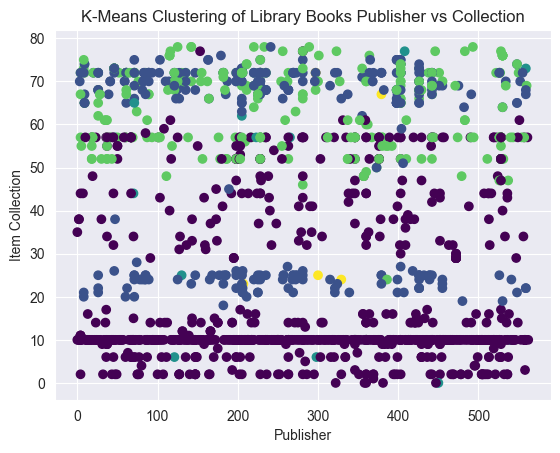

In [92]:
plt.scatter(full_data_books['Publisher_Label'], full_data_books['ItemCollection_Label'], c=full_data_books['KMeans_Cluster'], cmap='viridis')
plt.xlabel('Publisher')
plt.ylabel('Item Collection')
plt.title('K-Means Clustering of Library Books Publisher vs Collection')
plt.show()

Відносно вимірів типу книги та локації:

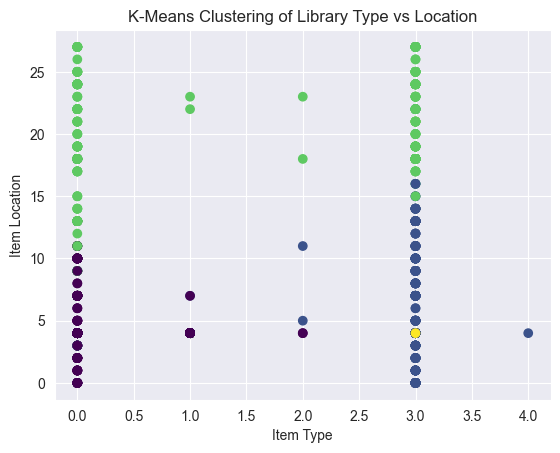

In [93]:
plt.scatter(full_data_books['ItemType_Label'], full_data_books['ItemLocation_Label'], c=full_data_books['KMeans_Cluster'], cmap='viridis')
plt.xlabel('Item Type')
plt.ylabel('Item Location')
plt.title('K-Means Clustering of Library Type vs Location')
plt.show()

Виміри оцінки і кількості сторінок:

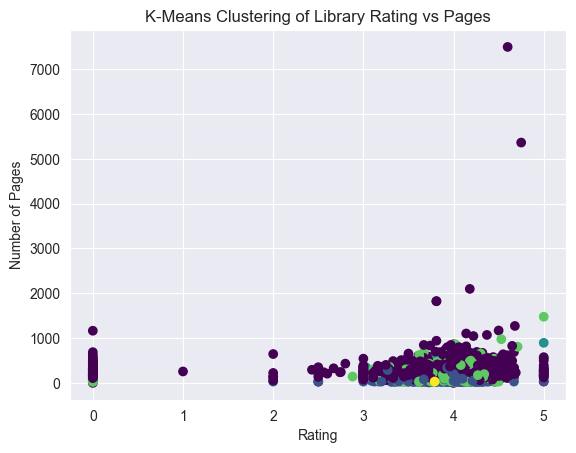

In [94]:
plt.scatter(full_data_books['Rating'], full_data_books['PagesNumber'], c=full_data_books['KMeans_Cluster'], cmap='viridis')
plt.xlabel('Rating')
plt.ylabel('Number of Pages')
plt.title('K-Means Clustering of Library Rating vs Pages')
plt.show()

### PCA

Спробуємо зменшити кількість вимірів із застосуванням PCA. Можна навіть порівняти із якимось із попередньо отриманих вимірів, наприклад, для наявних числових даних.

In [95]:
from sklearn.decomposition import PCA

In [96]:
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

In [97]:
full_data_books['PCA1_KMeans'] = features_pca[:, 0]
full_data_books['PCA2_KMeans'] = features_pca[:, 1]

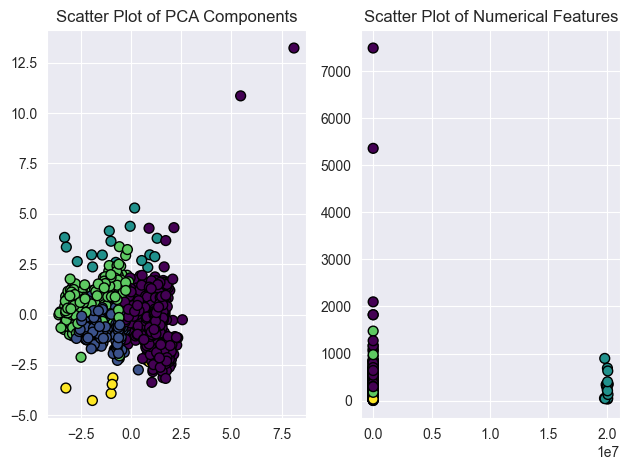

In [98]:
plt.subplot(1, 2, 1)
plt.scatter(full_data_books['PCA1_KMeans'], full_data_books['PCA2_KMeans'], c=full_data_books['KMeans_Cluster'], cmap='viridis', edgecolor='k', s=50)
plt.title('Scatter Plot of PCA Components')

plt.subplot(1, 2, 2)
plt.scatter(full_data_books['PublicationYear'], full_data_books['PagesNumber'], c=full_data_books['KMeans_Cluster'], cmap='viridis', edgecolor='k', s=50)
plt.title('Scatter Plot of Numerical Features')

plt.tight_layout()
plt.show()

### Агломеративна кластеризація

Кластеризація для цього набору даних може бути здійснена і за іншими алгоритмами, наприклад, цікавим може виявитись якогось роду ієрархічна кластеризація з врахуванням текстових стовпчиків як, власне, назва або певним чином опрацьований список тем.

In [99]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

Оберемо алгоритм агломеративного кластерінгу. Може бути цікавим розглянути кілька варіантів стосовно вхідних даних:
1. Брудний заголовок книги без підзаголовку.
2. Чистий заголовок книги без підзаголовку.
3. Повний брудний заголовок книги.
4. Повний чистий заголовок книги.

Під "брудним" заголовком розуміємо такий, що не пройшов обробку з видалення стоп-слів та лематизації. Враховуючи малу кількість слів у заголовку книг такі забруднені дані можуть також дати цікавий результат, який достатньо точно описує дійсність.

Створимо функції для очистки тексту заголовків та підзаголовків.

In [100]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\trush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\trush\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [101]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = nltk.word_tokenize(text)
    return tokens

In [102]:
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

In [103]:
def perform_lemmatization(tokens):
    lemmatizer = nltk.WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

In [104]:
def full_clean_text(text):
    if pd.notna(text):
        tokens = preprocess_text(text)
        filtered_tokens = remove_stopwords(tokens)
        lemmatized_tokens = perform_lemmatization(filtered_tokens)
        clean_text = ' '.join(lemmatized_tokens)
        return clean_text

Слід додати нові стовпчики у вибірку, які позначатимуть чистий загловок без підзаголовку, чистий заголовок із та брудний заголовок з підзаголовком (без помітної точки розділення).

In [105]:
full_data_books['Title_Clean'] = full_data_books['Title'].apply(full_clean_text)
full_data_books['Title_Subtitle'] = full_data_books['Title'] + ' ' + full_data_books['Subtitle'].fillna('')
full_data_books['Title_Subtitle_Clean'] = full_data_books['Title_Subtitle'].apply(full_clean_text)
full_data_books

,BibNum,Title,Subtitle,Author,ISBN10,ISBN13,PublicationYear,Publisher,Subjects,ItemType,...,ItemLocation_Label,Report_Year,Report_Month,Report_Day,KMeans_Cluster,PCA1_KMeans,PCA2_KMeans,Title_Clean,Title_Subtitle,Title_Subtitle_Clean
9,1995873,"Be here now, remember.",<NA>,Unknown,0517543052,<NA>,1978,hanuman foundation,"[Ram Dass, Spiritual life, New Age movement]",acbk,...,17,2020,11,1,3,-0.689822,1.977125,remember,"Be here now, remember.",remember
13,1879748,Romeo and Juliet,a guide to the play,Jay L. Halio,0313300895,<NA>,1998,greenwood,[Shakespeare William 1564 1616 Romeo and Julie...,acbk,...,4,2020,1,1,0,0.916392,-0.832596,romeo juliet,Romeo and Juliet a guide to the play,romeo juliet guide play
14,1792215,William Shakespeare's Macbeth,<NA>,Bruce Coville,0803718993,<NA>,1997,dial,[Macbeth King of Scotland active 11th century ...,jcbk,...,18,2020,9,1,3,-2.727767,-0.604490,william shakespeare macbeth,William Shakespeare's Macbeth,william shakespeare macbeth
19,532422,The economics of chaos,on revitalizing the American economy,Eliot Janeway,0525247114,<NA>,1989,dutton,"[Economic history 1945, United States Economic...",acbk,...,4,2020,6,1,0,1.863269,-2.408769,economics chaos,The economics of chaos on revitalizing the Ame...,economics chaos revitalizing american economy
25,1887390,New York,an illustrated history,Ric Burns,0679454829,<NA>,1999,knopf,"[New York N Y History, New York N Y History Pi...",acbk,...,4,2020,11,1,0,1.439754,1.414033,new york,New York an illustrated history,new york illustrated history
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10231,1590997,The red and the black,<NA>,Unknown,0679601627,<NA>,1995,modern library,"[Young men France Fiction, France Social life ...",acbk,...,4,2020,2,1,0,1.739607,0.958976,red black,The red and the black,red black
10238,2458864,Communication revolution,critical junctures and the future of media,Robert Waterman McChesney,159558207X,9781595582072,2007,new,[Communication History 21st century Forecasting],acbk,...,4,2020,7,1,0,1.380441,0.376588,communication revolution,Communication revolution critical junctures an...,communication revolution critical juncture fut...
10243,2455011,Sleepover Larry,<NA>,Daniel Manus Pinkwater,0761453148,9780761453147,2007,marshall cavendish,"[Polar bear Juvenile fiction, Sleepovers Juven...",jcbk,...,4,2022,9,1,4,-0.929154,-3.460962,sleepover larry,Sleepover Larry,sleepover larry
10246,2724228,Experimental drawing,<NA>,Robert Kaupelis,0823016188,9780823016181,1980,watson guptill,"[Drawing Study and teaching, Drawing Technique]",acbk,...,22,2020,9,1,3,-0.994961,1.981583,experimental drawing,Experimental drawing,experimental drawing


Здійснимо кластерінг на отриманих даних і продемонструємо результат.

In [106]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [107]:
numerical_cols = ['PublicationYear', 'PagesNumber', 'Rating', 'Report_Year']
categorical_cols = ['Author', 'Publisher', 'ItemType', 'ItemCollection', 'ItemLocation']
text_cols = ['Title']

In [108]:
numerical_data = full_data_books[numerical_cols].copy()
categorical_data = full_data_books[categorical_cols].copy()
text_data = full_data_books[text_cols].copy()

In [109]:
from sklearn.base import TransformerMixin
class DendrogramTransformer(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.toarray()

In [110]:
preprocessor = ColumnTransformer( transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(), categorical_cols),
    ('text', TfidfVectorizer(), 'Title')
])

In [111]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('to_dense', DendrogramTransformer()),
    ('agglo', AgglomerativeClustering(n_clusters=5))
])

In [112]:
full_data_books['Agglo_Cluster_TD'] = pipeline.fit_predict(full_data_books[numerical_cols + categorical_cols + text_cols])
full_data_books

,BibNum,Title,Subtitle,Author,ISBN10,ISBN13,PublicationYear,Publisher,Subjects,ItemType,...,Report_Year,Report_Month,Report_Day,KMeans_Cluster,PCA1_KMeans,PCA2_KMeans,Title_Clean,Title_Subtitle,Title_Subtitle_Clean,Agglo_Cluster_TD
9,1995873,"Be here now, remember.",<NA>,Unknown,0517543052,<NA>,1978,hanuman foundation,"[Ram Dass, Spiritual life, New Age movement]",acbk,...,2020,11,1,3,-0.689822,1.977125,remember,"Be here now, remember.",remember,0
13,1879748,Romeo and Juliet,a guide to the play,Jay L. Halio,0313300895,<NA>,1998,greenwood,[Shakespeare William 1564 1616 Romeo and Julie...,acbk,...,2020,1,1,0,0.916392,-0.832596,romeo juliet,Romeo and Juliet a guide to the play,romeo juliet guide play,0
14,1792215,William Shakespeare's Macbeth,<NA>,Bruce Coville,0803718993,<NA>,1997,dial,[Macbeth King of Scotland active 11th century ...,jcbk,...,2020,9,1,3,-2.727767,-0.604490,william shakespeare macbeth,William Shakespeare's Macbeth,william shakespeare macbeth,1
19,532422,The economics of chaos,on revitalizing the American economy,Eliot Janeway,0525247114,<NA>,1989,dutton,"[Economic history 1945, United States Economic...",acbk,...,2020,6,1,0,1.863269,-2.408769,economics chaos,The economics of chaos on revitalizing the Ame...,economics chaos revitalizing american economy,4
25,1887390,New York,an illustrated history,Ric Burns,0679454829,<NA>,1999,knopf,"[New York N Y History, New York N Y History Pi...",acbk,...,2020,11,1,0,1.439754,1.414033,new york,New York an illustrated history,new york illustrated history,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10231,1590997,The red and the black,<NA>,Unknown,0679601627,<NA>,1995,modern library,"[Young men France Fiction, France Social life ...",acbk,...,2020,2,1,0,1.739607,0.958976,red black,The red and the black,red black,0
10238,2458864,Communication revolution,critical junctures and the future of media,Robert Waterman McChesney,159558207X,9781595582072,2007,new,[Communication History 21st century Forecasting],acbk,...,2020,7,1,0,1.380441,0.376588,communication revolution,Communication revolution critical junctures an...,communication revolution critical juncture fut...,0
10243,2455011,Sleepover Larry,<NA>,Daniel Manus Pinkwater,0761453148,9780761453147,2007,marshall cavendish,"[Polar bear Juvenile fiction, Sleepovers Juven...",jcbk,...,2022,9,1,4,-0.929154,-3.460962,sleepover larry,Sleepover Larry,sleepover larry,2
10246,2724228,Experimental drawing,<NA>,Robert Kaupelis,0823016188,9780823016181,1980,watson guptill,"[Drawing Study and teaching, Drawing Technique]",acbk,...,2020,9,1,3,-0.994961,1.981583,experimental drawing,Experimental drawing,experimental drawing,0


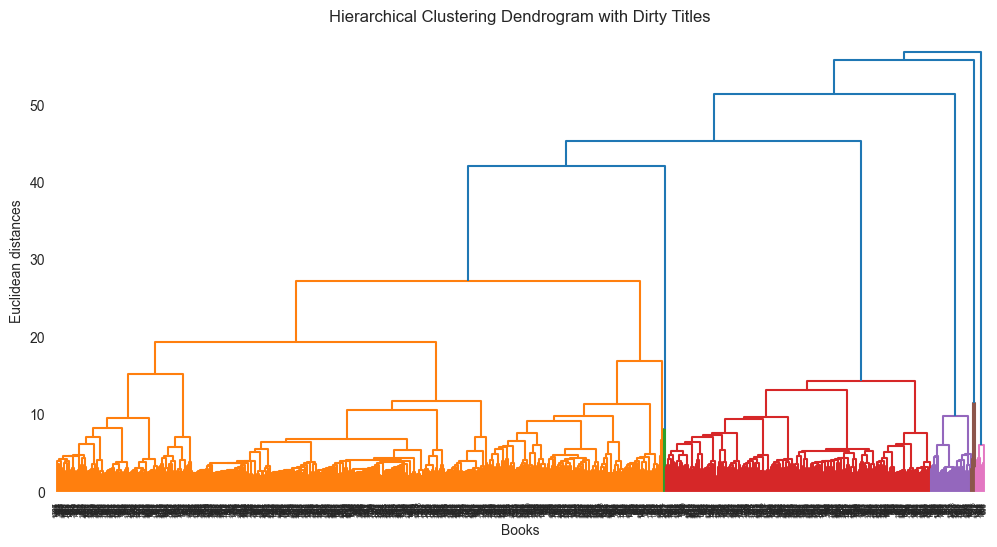

In [113]:
linked = linkage(pipeline.named_steps['preprocessor'].transform(full_data_books[numerical_cols + categorical_cols + text_cols]).toarray(), 'ward')
plt.figure(figsize=(12, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram with Dirty Titles')
plt.xlabel('Books')
plt.ylabel('Euclidean distances')
plt.show()

Повторимо даний процес для забруднених заголовків із забрудненими підзаголовками

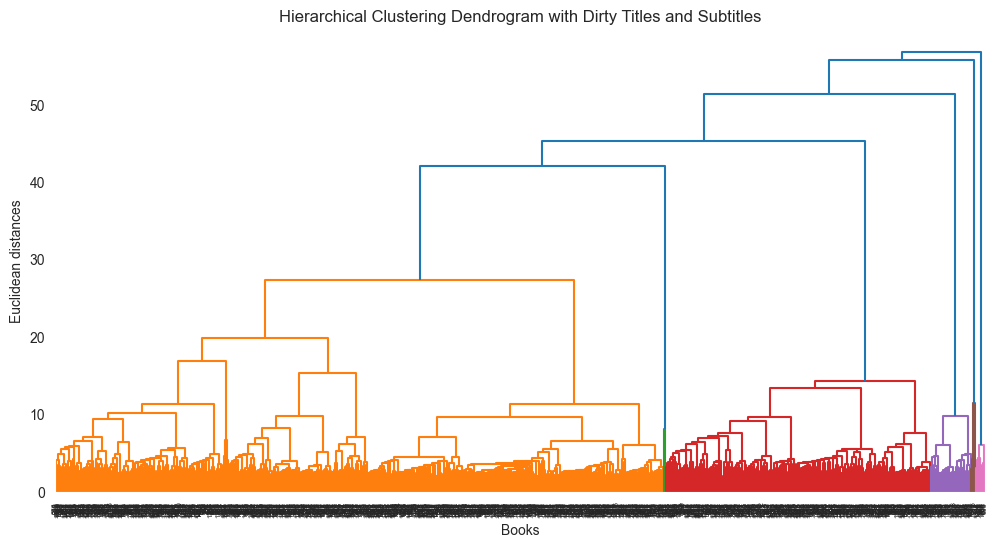

In [114]:
numerical_cols = ['PublicationYear', 'PagesNumber', 'Rating', 'Report_Year']
categorical_cols = ['Author', 'Publisher', 'ItemType', 'ItemCollection', 'ItemLocation']
text_cols = ['Title_Subtitle']

preprocessor = ColumnTransformer( transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(), categorical_cols),
    ('text', TfidfVectorizer(), 'Title_Subtitle')
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('to_dense', DendrogramTransformer()),
    ('agglo', AgglomerativeClustering(n_clusters=5))
])

full_data_books['Agglo_Cluster_TSD'] = pipeline.fit_predict(full_data_books[numerical_cols + categorical_cols + text_cols])

linked = linkage(pipeline.named_steps['preprocessor'].transform(full_data_books[numerical_cols + categorical_cols + text_cols]).toarray(), 'ward')
plt.figure(figsize=(12, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram with Dirty Titles and Subtitles')
plt.xlabel('Books')
plt.ylabel('Euclidean distances')
plt.show()

Можна порівняти з очищеними даними:

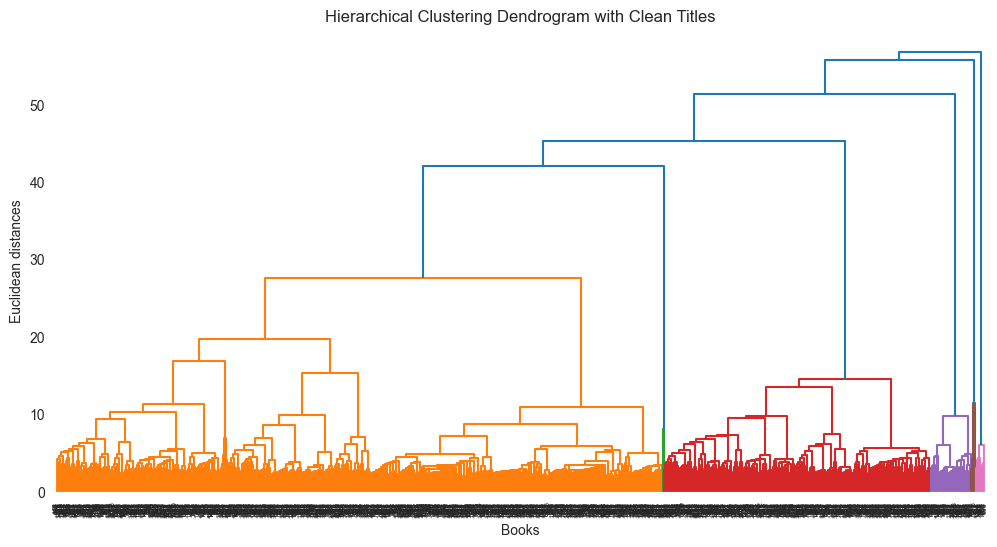

In [115]:
numerical_cols = ['PublicationYear', 'PagesNumber', 'Rating', 'Report_Year']
categorical_cols = ['Author', 'Publisher', 'ItemType', 'ItemCollection', 'ItemLocation']
text_cols = ['Title_Clean']

preprocessor = ColumnTransformer( transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(), categorical_cols),
    ('text', TfidfVectorizer(), 'Title_Clean')
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('to_dense', DendrogramTransformer()),
    ('agglo', AgglomerativeClustering(n_clusters=5))
])

full_data_books['Agglo_Cluster_TC'] = pipeline.fit_predict(full_data_books[numerical_cols + categorical_cols + text_cols])

linked = linkage(pipeline.named_steps['preprocessor'].transform(full_data_books[numerical_cols + categorical_cols + text_cols]).toarray(), 'ward')
plt.figure(figsize=(12, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram with Clean Titles')
plt.xlabel('Books')
plt.ylabel('Euclidean distances')
plt.show()

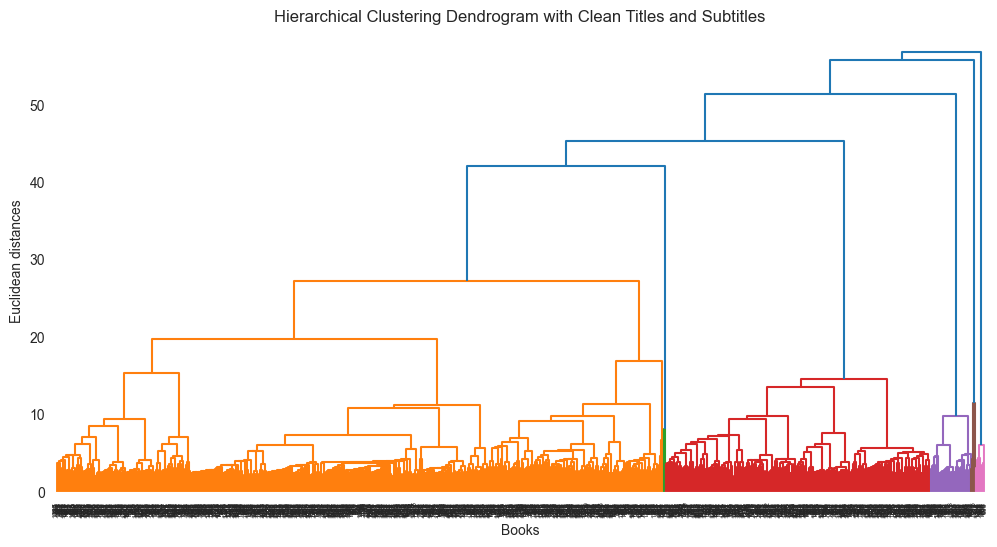

In [116]:
numerical_cols = ['PublicationYear', 'PagesNumber', 'Rating', 'Report_Year']
categorical_cols = ['Author', 'Publisher', 'ItemType', 'ItemCollection', 'ItemLocation']
text_cols = ['Title_Subtitle_Clean']

preprocessor = ColumnTransformer( transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(), categorical_cols),
    ('text', TfidfVectorizer(), 'Title_Subtitle_Clean')
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('to_dense', DendrogramTransformer()),
    ('agglo', AgglomerativeClustering(n_clusters=5))
])

full_data_books['Agglo_Cluster_TSD'] = pipeline.fit_predict(full_data_books[numerical_cols + categorical_cols + text_cols])

linked = linkage(pipeline.named_steps['preprocessor'].transform(full_data_books[numerical_cols + categorical_cols + text_cols]).toarray(), 'ward')
plt.figure(figsize=(12, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram with Clean Titles and Subtitles')
plt.xlabel('Books')
plt.ylabel('Euclidean distances')
plt.show()

Чисто візуально можна помітити, що зміни в очищенні даних для назви книги вносять на даній вибірці для Агломеративного алгоритму кластеризації відносно незначні зміни у зовнішній вигляд ієрархії кластерів. Проте, слід зазначити, що весь процес кластеризації для очищених даних заголовків і підзаголовків, згідно власних обрахунків PyCharm, на комп'ютері, на якому була виконана дана робота, займає в середньому на 1 секунду менше (приблизно на 6% швидше). Гіпотеза щодо того, що на очищених даних даний алгоритм кластеризації працюватиме швидше не суперечить здоровому глузду і може бути розглянута в подальших дослідженнях для різних вибірок і більшого об'єму даних. 

### Класифікація за моделлю Random Forest

Здійснимо класифікацію книг за допомогою методу Random Forest, який, побудований на використанні множини дерев вибору в процесі навчання. Дослідимо точність з якою на даній вибірці можливо здійснити передбачення колекції, до якої належить книга за її іншими ознаками. Спочатку здійснимо експеримент ігноруючи назву книги та її теми. 

In [153]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [154]:
X = full_data_books[['Author', 'Publisher', 'PublicationYear', 'PagesNumber', 'Rating', 'ItemType', 'ItemLocation']]
y = full_data_books['ItemCollection']

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [156]:
numerical_cols = ['PublicationYear', 'PagesNumber', 'Rating']
categorical_cols = ['Author', 'Publisher', 'ItemType', 'ItemLocation']

In [157]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

In [158]:
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=3))
    ]
)

In [159]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['PublicationYear',
                                                   'PagesNumber', 'Rating']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Author', 'Publisher',
                                                   'ItemType',
                                                   'ItemLocation'])])),
                ('classifier', RandomForestClassifier(random_state=3))])

In [160]:
y_pred = pipeline.predict(X_test)

In [161]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.616822429906542

In [162]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

      caaero       0.00      0.00      0.00         1
         cab       0.00      0.00      0.00        16
        cabr       0.00      0.00      0.00         1
      caesli       0.00      0.00      0.00         1
       cafic       1.00      0.14      0.25         7
       cagbi       0.00      0.00      0.00         2
        cagr       0.00      0.00      0.00         1
       camys       0.00      0.00      0.00         1
        canf       0.78      1.00      0.87       122
      caover       0.00      0.00      0.00         2
        capf       0.00      0.00      0.00         1
       caref       0.21      0.80      0.33         5
      caref8       0.00      0.00      0.00         1
       casea       0.00      0.00      0.00         5
       ccfft       0.00      0.00      0.00         3
       ccfic       0.50      1.00      0.67         1
       cchol       0.00      0.00      0.00         4
        ccnf       0.00    

C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\en

In [163]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

Бачимо, що виникає проблема, пов'язана із надмірною кількістю категористичних даних відносно вибірки. У тренувальному наборі моделі банально відсутня значна кількість категорій, які потім з'являються в тестовому наборі. Таким чином, ми в середньому отримуємо досить погане передбачення. Висуваємо гіпотезу, що найбільше проблем виникає в зв'язку з надмірним різноманіттям авторів. Перевіримо дану гіпотезу, здійснивши класифікацію без врахування даних про автора.

In [127]:
X = full_data_books[['Publisher', 'PublicationYear', 'PagesNumber', 'Rating', 'ItemType', 'ItemLocation']]
y = full_data_books['ItemCollection']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

numerical_cols = ['PublicationYear', 'PagesNumber', 'Rating']
categorical_cols = ['Publisher', 'ItemType', 'ItemLocation']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=3))
    ]
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy

0.632398753894081

In [128]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

      caaero       0.00      0.00      0.00         1
     caatlas       0.00      0.00      0.00         1
         cab       0.00      0.00      0.00        16
       cafic       0.00      0.00      0.00         8
       cagbi       0.00      0.00      0.00         1
       camys       1.00      0.25      0.40         4
        canf       0.75      0.99      0.86       102
        capf       1.00      1.00      1.00         1
       caref       0.42      1.00      0.59         5
       casea       0.00      0.00      0.00         2
        casf       0.00      0.00      0.00         2
        ccef       0.00      0.00      0.00         2
       ccfft       1.00      0.67      0.80         3
       ccfic       1.00      1.00      1.00         2
       cchol       0.00      0.00      0.00         3
        ccnf       0.00      0.00      0.00         4
       ccpic       0.57      1.00      0.73         8
       ccrdr       0.00    

C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\en

In [129]:
full_data_books['ItemCollection'].nunique()

79

In [130]:
full_data_books['ItemCollection'].value_counts()

ItemCollection
canf       536
ncpic      134
nanf       117
cab         62
nafic       57
          ... 
ch1mcse      1
naesli       1
ccaward      1
caesli       1
cyb          1
Name: count, Length: 79, dtype: Int64

In [131]:
full_data_books['ItemCollection'].value_counts().value_counts()

count
1      14
2      10
3       7
4       7
6       4
11      4
23      3
12      3
5       2
9       2
14      2
20      2
15      2
24      1
8       1
117     1
62      1
57      1
53      1
46      1
7       1
39      1
18      1
10      1
37      1
36      1
13      1
25      1
134     1
536     1
Name: count, dtype: Int64

Після незначного підкручування коефіцієнтів, ми експериментально знайшли підтвердження гіпотези, що за відсутності даних про авторів, Random Forest може дати більшу точність передбачення для даної вибірки.

Ще одна проблема, яку можна врахувати - незбалансованість вибірки відносно 'ItemCollection'. Можна спробувати виправити це, надавши білше ваги більш рідкісним категоріям, за якими здійснюється класифікація.

In [132]:
X = full_data_books[['Publisher', 'PublicationYear', 'PagesNumber', 'Rating', 'ItemType', 'ItemLocation']]
y = full_data_books['ItemCollection']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

numerical_cols = ['PublicationYear', 'PagesNumber', 'Rating']
categorical_cols = ['Publisher', 'ItemType', 'ItemLocation']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=3, class_weight='balanced'))
    ]
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy

0.632398753894081

In [133]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

      caaero       0.00      0.00      0.00         1
     caatlas       0.00      0.00      0.00         1
         cab       0.00      0.00      0.00        16
       cafic       0.00      0.00      0.00         8
       cagbi       0.00      0.00      0.00         1
       camys       1.00      0.25      0.40         4
        canf       0.75      1.00      0.86       102
        capf       1.00      1.00      1.00         1
       caref       0.42      1.00      0.59         5
       casea       0.00      0.00      0.00         2
        casf       0.00      0.00      0.00         2
        ccef       0.00      0.00      0.00         2
       ccfft       0.00      0.00      0.00         3
       ccfic       1.00      0.50      0.67         2
       cchol       0.00      0.00      0.00         3
        ccnf       0.00      0.00      0.00         4
       ccpic       0.62      1.00      0.76         8
       ccrdr       0.00    

C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\en

Бачимо, що додавання параметра class_weight='balanced' для моделі Random forest абсолютно ніяк не вплинула на точність класифікації. Це не означає, що проблеми із незбалансованістю даних не існує, але чітко демонструє, що запропоноване рішення не підходить для даної задачі. Питання стосовно збалансування даної вибірки може бути предметом для подальших досліджень.

Можна висунути гіпотезу, що попри труднощі класифікації, що виникають в зв'язку із незбалансованістю вибірки, ми можемо покращити точність класифікації, додавши дані стосовно слів, що використовуються у повній назві книги. Власне, в таком разі нульовою гіпотезою буде "класифікація з додаванням інформації про назву книги не буде відрізнятися за точністю від класифікації без даних про назву книги".

In [134]:
X = full_data_books[['Publisher', 'PublicationYear', 'PagesNumber', 'Rating', 'ItemType', 'ItemLocation', 'Title_Subtitle_Clean']]
y = full_data_books['ItemCollection']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

numerical_cols = ['PublicationYear', 'PagesNumber', 'Rating']
categorical_cols = ['Publisher', 'ItemType', 'ItemLocation']
text_cols = ['Title_Subtitle_Clean']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('text', TfidfVectorizer(), 'Title_Subtitle_Clean')
    ]
)

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=3, class_weight='balanced'))
    ]
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy

0.6573208722741433

In [135]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

      caaero       0.00      0.00      0.00         1
     caatlas       0.00      0.00      0.00         1
         cab       0.00      0.00      0.00        16
       cafic       0.00      0.00      0.00         8
       cagbi       0.00      0.00      0.00         1
       camys       0.00      0.00      0.00         4
        canf       0.74      1.00      0.85       102
        capf       1.00      1.00      1.00         1
       caref       0.36      1.00      0.53         5
       casea       0.00      0.00      0.00         2
        casf       0.00      0.00      0.00         2
        ccef       0.00      0.00      0.00         2
       ccfft       0.00      0.00      0.00         3
       ccfic       1.00      1.00      1.00         2
       cchol       0.00      0.00      0.00         3
        ccnf       0.00      0.00      0.00         4
       ccpic       0.40      1.00      0.57         8
       ccrdr       1.00    

C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Спостерігаємо невелике покращення показників класифікації. Вважаємо, що цього покращення достатньо, щоб відкинути нульову гіпотезу і стверджувати, що класифікація з використанням моделі Random forest дає кращі результати за умови "згодовування" їй даних про назву книги.

### Класифікація за допомогою SVC

Здійснимо класифікацю книг за допомогою Support Vector Machines алгоритмів. Даний метод був обраний для цієї вибірки через її відносно велику вимірність і здатність цих алгоритмів ефективно справлятися із проблемами, які в таких вибірках виникають. Спочатку перевіримо точність моделі за умови використання нею тільки категористичних та цифрових даних, а далі порівняємо отримані результати із результатами за умови додавання даних про назву книги. Для даного експерименту інформацію про автора враховувати в обох випадках не будемо.

In [136]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [137]:
X = full_data_books[['Publisher', 'PublicationYear', 'PagesNumber', 'Rating', 'ItemType', 'ItemLocation']]
y = full_data_books['ItemCollection']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

numerical_cols = ['PublicationYear', 'PagesNumber', 'Rating']
categorical_cols = ['Publisher', 'ItemType', 'ItemLocation']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='linear', C=1, class_weight='balanced', random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

      caaero       0.00      0.00      0.00         2
         cab       0.08      0.27      0.13        11
        cabr       0.00      0.00      0.00         1
       cadoc       0.00      0.00      0.00         3
       cafic       0.22      0.22      0.22         9
       cagbi       0.00      0.00      0.00         1
       camys       0.20      0.25      0.22         4
        canf       0.79      0.57      0.66       124
      caover       0.00      0.00      0.00         1
        capf       1.00      1.00      1.00         1
       caref       0.40      1.00      0.57         6
       casea       0.00      0.00      0.00         2
        casf       0.00      0.00      0.00         0
     cccomic       0.00      0.00      0.00         1
        ccef       0.00      0.00      0.00         2
       ccfft       0.00      0.00      0.00         1
       ccfic       0.67      1.00      0.80         2
        ccnf       0.30    

C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\en

In [138]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 3, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 3, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=int64)

Бачимо, що чисто на нетекстових даних в межах нашої вибірки, на відміну від наших очікувань, точність класифікації з SVC помітно нижча, ніж для Random forest. Порівняємо із точністю класифікації для даних з додаванням інформації про назву книги.

In [139]:
X = full_data_books[['Publisher', 'PublicationYear', 'PagesNumber', 'Rating', 'ItemType', 'ItemLocation', 'Title_Subtitle_Clean']]
y = full_data_books['ItemCollection']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

numerical_cols = ['PublicationYear', 'PagesNumber', 'Rating']
categorical_cols = ['Publisher', 'ItemType', 'ItemLocation']
text_cols = ['Title_Subtitle_Clean']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('text', TfidfVectorizer(), 'Title_Subtitle_Clean')
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='linear', C=1, class_weight='balanced', random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

      caaero       0.00      0.00      0.00         2
         cab       0.13      0.45      0.20        11
        cabr       0.00      0.00      0.00         1
       cadoc       0.00      0.00      0.00         3
       cafic       0.20      0.22      0.21         9
       cagbi       0.00      0.00      0.00         1
       camys       0.50      0.25      0.33         4
        canf       0.77      0.66      0.71       124
      caover       0.00      0.00      0.00         1
        capf       1.00      1.00      1.00         1
       caref       0.38      1.00      0.55         6
       casea       0.00      0.00      0.00         2
     cccomic       0.00      0.00      0.00         1
        ccef       0.00      0.00      0.00         2
       ccfft       0.00      0.00      0.00         1
       ccfic       0.50      0.50      0.50         2
        ccnf       0.60      0.60      0.60         5
       ccpic       0.29    

C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\en

З додаванням текстових даних SVC дає дещо кращий результат, проте все ще гірший, ніж відповідні результати для Random forest.

### Класифікація з Gradient Boosting

Gradient boosting використовує комбінацію слабких дерев вибору для здійснення задач класифікації. Вважається використання даного алгоритму дає в загальному кращі результати, ніж Random forest. Приймемо це як нашу гіпотезу для даного експерименту і, аналогічно із попередніми алгоритмами, здійснимо класифікацію для даних без використання назви книги та з і порівняємо отримані результати між собою.

In [140]:
from sklearn.ensemble import GradientBoostingClassifier

In [141]:
X = full_data_books[['Publisher', 'PublicationYear', 'PagesNumber', 'Rating', 'ItemType', 'ItemLocation']]
y = full_data_books['ItemCollection']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

numerical_cols = ['PublicationYear', 'PagesNumber', 'Rating']
categorical_cols = ['Publisher', 'ItemType', 'ItemLocation']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=7))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

      caaero       0.00      0.00      0.00         3
         cab       0.00      0.00      0.00        12
      caesli       0.00      0.00      0.00         1
       cafic       0.00      0.00      0.00        11
       cagbi       0.00      0.00      0.00         1
        cagr       0.00      0.00      0.00         1
       camys       0.33      0.33      0.33         3
        canf       0.80      0.88      0.84       112
      caover       0.00      0.00      0.00         0
      caread       0.00      0.00      0.00         0
       caref       0.11      0.67      0.19         3
       casea       0.00      0.00      0.00         3
        casf       0.00      0.00      0.00         0
        ccef       0.00      0.00      0.00         0
       ccfft       0.00      0.00      0.00         2
       ccfic       0.50      0.40      0.44         5
       cchol       0.00      0.00      0.00         3
        ccnf       0.17    

C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\en

Цікаво, що на даному етапі точність нижча, ніж для Random forest. Додамо дані про назву книги.

In [142]:
X = full_data_books[['Publisher', 'PublicationYear', 'PagesNumber', 'Rating', 'ItemType', 'ItemLocation', 'Title_Subtitle_Clean']]
y = full_data_books['ItemCollection']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

numerical_cols = ['PublicationYear', 'PagesNumber', 'Rating']
categorical_cols = ['Publisher', 'ItemType', 'ItemLocation']
text_cols = ['Title_Subtitle_Clean']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('text', TfidfVectorizer(), 'Title_Subtitle_Clean')
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=9))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

      caaero       0.00      0.00      0.00         3
         cab       0.33      0.08      0.13        12
      caesli       0.00      0.00      0.00         1
       cafic       0.20      0.09      0.13        11
       cagbi       0.00      0.00      0.00         1
        cagr       0.00      0.00      0.00         1
       camys       0.00      0.00      0.00         3
        canf       0.75      0.87      0.80       112
      caover       0.00      0.00      0.00         0
      caread       0.00      0.00      0.00         0
       caref       0.16      1.00      0.27         3
      caref8       0.00      0.00      0.00         0
       casea       0.50      0.33      0.40         3
        casf       0.00      0.00      0.00         0
        ccef       0.00      0.00      0.00         0
       ccfft       0.00      0.00      0.00         2
       ccfic       0.00      0.00      0.00         5
       cchol       0.00    

C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\en

Висловлена гіпотеза не підтвердилась. На даному наборі даних Gradient Boosting здійснює класифікацію з нижчою точністю, наж Random Forest.

### Класифікація вибірки з малою кількістю числових даних

Як можна було побачити в огляді алгоритмів класифікації на вибірці, для якої з обраного, зовнішнього відносно базового набору даних, джерела були додані дані про кількість сторінок та користувацьку оцінку, значну роль в точності передбачення відіграють:
1. Велика відносно розміру вибірки кількість категорій, на яких здійснюється класифікація - результати роботи стають менш точними, оскільки певні класи можуть не потрапити до тренувального набору даних або взагалі бути присутніми тільки один раз на всю вибірку
2. Додавання інших типів даних для класифікації окрім числових та категористичних - для всіх алгоритмів спостерігалося підвищення точності при додаванні текстових даних заголовку книги як вхідних для класифікації.

Таким чином, можна припустити, що хоча числові дані безумовно важливі, але, можливо, ми можемо здійснювати класифікацію ефективно і на базовій вибірці даних. Висунемо гіпотезу про те, що точність класифікації на даній вибірці виграє від збільшення її розміру більше, ніж від збільшення її повноти за рахунок зовнішніх даних. 

In [143]:
books

,BibNum,Title,Subtitle,Author,ISBN10,ISBN13,PublicationYear,Publisher,Subjects,ItemType,ItemCollection,ItemLocation,ReportDate,ItemCount
0,3479509,Franklin and Luna and the book of fairy tales,None,Jen Campbell,0500651752,9780500651759,2019,thames hudson,"Dragons Juvenile fiction, Characters and chara...",jcbk,ncnew,net,03/01/2020,1
1,2737917,Holiday dinners with Bradley Ogden,150 festive recipes for bringing family & frie...,Bradley Ogden,0762439157,9780762439157,2011,running,"Cooking, Holiday cooking",acbk,nanf,swt,12/01/2020,1
2,3359831,"Cuzco, Machu Picchu & the Inca heartland",None,Robert Kunstaetter,1911082256,9781911082255,2017,footprint,"Peru Guidebooks, Cuzco Peru Guidebooks, Machu ...",acbk,nanf,wts,03/01/2020,1
3,3298424,Sleeping Beauty,None,Cynthia Rylant,1423121082,9781423121084,2015,disney hyperion,"Sleeping Beauty Tale Juvenile literature, Folk...",jcbk,ncfft,mag,11/01/2020,1
4,3203995,How to escape from a leper colony,a novella and stories,Tiphanie Yanique,155597550X,9781555975500,2010,graywolf,"United States Virgin Islands Fiction, Short st...",acbk,cafic,cen,05/01/2020,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10244,2760306,Lover reborn,None,J. R. Ward,0451235843,9780451235848,2012,new american library,"Vampires Fiction, Paranormal romance stories, ...",acbk,nafic,dlr,10/01/2020,1
10245,2724228,Experimental drawing,None,Robert Kaupelis,0823016188,9780823016181,1980,watson guptill,"Drawing Study and teaching, Drawing Technique",acbk,nanf,rbe,09/01/2020,1
10246,3364815,The bad guys in Alien vs. Bad Guys,None,Aaron Blabey,133818959X,9781338189599,2018,scholastic,"Extraterrestrial beings Juvenile fiction, Kidn...",jcbk,ncef,glk,10/01/2020,1
10247,3227571,English for everyone. Course book. Level 3 int...,None,Gill Johnson,1465447636,9781465447630,2016,dk,"English language Self instruction, English lan...",bcbk,naesli,col,03/01/2020,1


In [144]:
books_classy = books.copy()
books_classy

,BibNum,Title,Subtitle,Author,ISBN10,ISBN13,PublicationYear,Publisher,Subjects,ItemType,ItemCollection,ItemLocation,ReportDate,ItemCount
0,3479509,Franklin and Luna and the book of fairy tales,None,Jen Campbell,0500651752,9780500651759,2019,thames hudson,"Dragons Juvenile fiction, Characters and chara...",jcbk,ncnew,net,03/01/2020,1
1,2737917,Holiday dinners with Bradley Ogden,150 festive recipes for bringing family & frie...,Bradley Ogden,0762439157,9780762439157,2011,running,"Cooking, Holiday cooking",acbk,nanf,swt,12/01/2020,1
2,3359831,"Cuzco, Machu Picchu & the Inca heartland",None,Robert Kunstaetter,1911082256,9781911082255,2017,footprint,"Peru Guidebooks, Cuzco Peru Guidebooks, Machu ...",acbk,nanf,wts,03/01/2020,1
3,3298424,Sleeping Beauty,None,Cynthia Rylant,1423121082,9781423121084,2015,disney hyperion,"Sleeping Beauty Tale Juvenile literature, Folk...",jcbk,ncfft,mag,11/01/2020,1
4,3203995,How to escape from a leper colony,a novella and stories,Tiphanie Yanique,155597550X,9781555975500,2010,graywolf,"United States Virgin Islands Fiction, Short st...",acbk,cafic,cen,05/01/2020,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10244,2760306,Lover reborn,None,J. R. Ward,0451235843,9780451235848,2012,new american library,"Vampires Fiction, Paranormal romance stories, ...",acbk,nafic,dlr,10/01/2020,1
10245,2724228,Experimental drawing,None,Robert Kaupelis,0823016188,9780823016181,1980,watson guptill,"Drawing Study and teaching, Drawing Technique",acbk,nanf,rbe,09/01/2020,1
10246,3364815,The bad guys in Alien vs. Bad Guys,None,Aaron Blabey,133818959X,9781338189599,2018,scholastic,"Extraterrestrial beings Juvenile fiction, Kidn...",jcbk,ncef,glk,10/01/2020,1
10247,3227571,English for everyone. Course book. Level 3 int...,None,Gill Johnson,1465447636,9781465447630,2016,dk,"English language Self instruction, English lan...",bcbk,naesli,col,03/01/2020,1


In [145]:
books_classy['Title'] = books_classy['Title'].astype('string')
books_classy['Subtitle'] = books_classy['Subtitle'].astype('string')
books_classy['Author'] = books_classy['Author'].astype('string')
books_classy = books_classy.dropna(subset=['PublicationYear'])
books_classy['PublicationYear'] = books_classy['PublicationYear'].astype('int')
books_classy['ItemType'] = books_classy['ItemType'].astype('string')
books_classy['ItemLocation'] = books_classy['ItemLocation'].astype('string')
books_classy['Publisher'] = books_classy['Publisher'].astype('string')
books_classy.dtypes

C:\Users\trush\AppData\Local\Temp\ipykernel_24508\3603912631.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_classy['PublicationYear'] = books_classy['PublicationYear'].astype('int')
C:\Users\trush\AppData\Local\Temp\ipykernel_24508\3603912631.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_classy['ItemType'] = books_classy['ItemType'].astype('string')
C:\Users\trush\AppData\Local\Temp\ipykernel_24508\3603912631.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

BibNum                      int64
Title              string[python]
Subtitle           string[python]
Author             string[python]
ISBN10             string[python]
ISBN13             string[python]
PublicationYear             int32
Publisher          string[python]
Subjects           string[python]
ItemType           string[python]
ItemCollection     string[python]
ItemLocation       string[python]
ReportDate                 object
ItemCount                   int64
dtype: object

In [146]:
books_classy['Title_Clean'] = books_classy['Title'].apply(full_clean_text)
books_classy['Title_Subtitle'] = books_classy['Title'] + ' ' + books_classy['Subtitle'].fillna('')
books_classy['Title_Subtitle_Clean'] = books_classy['Title_Subtitle'].apply(full_clean_text)
books_classy

C:\Users\trush\AppData\Local\Temp\ipykernel_24508\3664070335.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_classy['Title_Clean'] = books_classy['Title'].apply(full_clean_text)
C:\Users\trush\AppData\Local\Temp\ipykernel_24508\3664070335.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_classy['Title_Subtitle'] = books_classy['Title'] + ' ' + books_classy['Subtitle'].fillna('')
C:\Users\trush\AppData\Local\Temp\ipykernel_24508\3664070335.py:3: SettingWithCopyWarning: 
A value is trying to

,BibNum,Title,Subtitle,Author,ISBN10,ISBN13,PublicationYear,Publisher,Subjects,ItemType,ItemCollection,ItemLocation,ReportDate,ItemCount,Title_Clean,Title_Subtitle,Title_Subtitle_Clean
0,3479509,Franklin and Luna and the book of fairy tales,<NA>,Jen Campbell,0500651752,9780500651759,2019,thames hudson,"Dragons Juvenile fiction, Characters and chara...",jcbk,ncnew,net,03/01/2020,1,franklin luna book fairy tale,Franklin and Luna and the book of fairy tales,franklin luna book fairy tale
1,2737917,Holiday dinners with Bradley Ogden,150 festive recipes for bringing family & frie...,Bradley Ogden,0762439157,9780762439157,2011,running,"Cooking, Holiday cooking",acbk,nanf,swt,12/01/2020,1,holiday dinner bradley ogden,Holiday dinners with Bradley Ogden 150 festive...,holiday dinner bradley ogden festive recipe br...
2,3359831,"Cuzco, Machu Picchu & the Inca heartland",<NA>,Robert Kunstaetter,1911082256,9781911082255,2017,footprint,"Peru Guidebooks, Cuzco Peru Guidebooks, Machu ...",acbk,nanf,wts,03/01/2020,1,cuzco machu picchu inca heartland,"Cuzco, Machu Picchu & the Inca heartland",cuzco machu picchu inca heartland
3,3298424,Sleeping Beauty,<NA>,Cynthia Rylant,1423121082,9781423121084,2015,disney hyperion,"Sleeping Beauty Tale Juvenile literature, Folk...",jcbk,ncfft,mag,11/01/2020,1,sleeping beauty,Sleeping Beauty,sleeping beauty
4,3203995,How to escape from a leper colony,a novella and stories,Tiphanie Yanique,155597550X,9781555975500,2010,graywolf,"United States Virgin Islands Fiction, Short st...",acbk,cafic,cen,05/01/2020,1,escape leper colony,How to escape from a leper colony a novella an...,escape leper colony novella story
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10244,2760306,Lover reborn,<NA>,J. R. Ward,0451235843,9780451235848,2012,new american library,"Vampires Fiction, Paranormal romance stories, ...",acbk,nafic,dlr,10/01/2020,1,lover reborn,Lover reborn,lover reborn
10245,2724228,Experimental drawing,<NA>,Robert Kaupelis,0823016188,9780823016181,1980,watson guptill,"Drawing Study and teaching, Drawing Technique",acbk,nanf,rbe,09/01/2020,1,experimental drawing,Experimental drawing,experimental drawing
10246,3364815,The bad guys in Alien vs. Bad Guys,<NA>,Aaron Blabey,133818959X,9781338189599,2018,scholastic,"Extraterrestrial beings Juvenile fiction, Kidn...",jcbk,ncef,glk,10/01/2020,1,bad guy alien v bad guy,The bad guys in Alien vs. Bad Guys,bad guy alien v bad guy
10247,3227571,English for everyone. Course book. Level 3 int...,<NA>,Gill Johnson,1465447636,9781465447630,2016,dk,"English language Self instruction, English lan...",bcbk,naesli,col,03/01/2020,1,english everyone course book level intermediate,English for everyone. Course book. Level 3 int...,english everyone course book level intermediate


##### Random forest, SVC, Gradient Boost із заголовком

In [147]:
X = full_data_books[['Publisher', 'PublicationYear', 'ItemType', 'ItemLocation', 'Title_Subtitle_Clean']]
y = full_data_books['ItemCollection']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19)

numerical_cols = ['PublicationYear']
categorical_cols = ['Publisher', 'ItemType', 'ItemLocation']
text_cols = ['Title_Subtitle_Clean']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('text', TfidfVectorizer(), 'Title_Subtitle_Clean')
    ]
)

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=4))
    ]
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

      caaero       0.00      0.00      0.00         2
         cab       0.33      0.06      0.10        18
        cabr       0.00      0.00      0.00         2
       cadoc       0.00      0.00      0.00         1
       cafic       0.60      0.17      0.26        18
       cagbi       0.00      0.00      0.00         1
        cagr       0.00      0.00      0.00         2
       camys       0.00      0.00      0.00         3
        canf       0.76      0.99      0.86       163
      caread       0.00      0.00      0.00         1
       caref       0.31      1.00      0.47         9
      caref8       0.00      0.00      0.00         2
       casea       0.00      0.00      0.00         5
     ccaward       0.00      0.00      0.00         1
        ccef       0.00      0.00      0.00         1
       ccfic       0.00      0.00      0.00         4
       cchol       0.00      0.00      0.00         2
        ccnf       0.00    

C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [148]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='linear', C=1, class_weight='balanced', random_state=17))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

      caaero       0.00      0.00      0.00         2
         cab       0.25      0.17      0.20        18
        cabr       0.00      0.00      0.00         2
       cadoc       0.00      0.00      0.00         1
      caesli       0.00      0.00      0.00         0
       cafic       0.33      0.11      0.17        18
       cagbi       0.00      0.00      0.00         1
        cagr       0.00      0.00      0.00         2
       camys       0.25      0.33      0.29         3
        canf       0.77      0.89      0.83       163
      caover       0.00      0.00      0.00         0
        capf       0.00      0.00      0.00         0
      caread       0.00      0.00      0.00         1
       caref       0.31      0.89      0.46         9
      caref8       0.00      0.00      0.00         2
       casea       1.00      0.20      0.33         5
        casf       0.00      0.00      0.00         0
     ccaward       0.00    

C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\en

In [149]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=11))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

      caaero       0.00      0.00      0.00         2
     caatlas       0.00      0.00      0.00         0
         cab       0.00      0.00      0.00        18
        cabr       0.00      0.00      0.00         2
       cadoc       0.00      0.00      0.00         1
       cafic       0.40      0.11      0.17        18
       cagbi       0.00      0.00      0.00         1
        cagr       0.00      0.00      0.00         2
       camys       0.00      0.00      0.00         3
        canf       0.70      0.86      0.77       163
      caover       0.00      0.00      0.00         0
        capf       0.00      0.00      0.00         0
      caread       0.00      0.00      0.00         1
       caref       0.33      1.00      0.50         9
      caref8       0.00      0.00      0.00         2
       casea       0.50      0.20      0.29         5
     ccaward       0.00      0.00      0.00         1
        ccef       0.00    

C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\en

Легко помітити, що для даних, які не були збагачені, тільки SVC алгоритм демонструє вищу якість класифікації, ніж це спостерігалося у збагачених даних.

##### Random forest, SVC, Gradient Boost без заголовка

In [150]:
X = full_data_books[['Publisher', 'PublicationYear', 'ItemType', 'ItemLocation']]
y = full_data_books['ItemCollection']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19)

numerical_cols = ['PublicationYear']
categorical_cols = ['Publisher', 'ItemType', 'ItemLocation']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ]
)

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=4))
    ]
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

      caaero       0.00      0.00      0.00         2
         cab       0.00      0.00      0.00        18
        cabr       0.00      0.00      0.00         2
       cadoc       0.00      0.00      0.00         1
      caesli       0.00      0.00      0.00         0
       cafic       0.33      0.06      0.10        18
       cagbi       0.00      0.00      0.00         1
        cagr       0.00      0.00      0.00         2
       camys       0.33      0.33      0.33         3
        canf       0.77      0.90      0.83       163
        capf       0.00      0.00      0.00         0
      caread       0.00      0.00      0.00         1
       caref       0.31      0.89      0.46         9
      caref8       0.00      0.00      0.00         2
       casea       1.00      0.20      0.33         5
        casf       0.00      0.00      0.00         0
     ccaward       0.00      0.00      0.00         1
        ccef       0.00    

C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\en

In [151]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='linear', C=1, class_weight='balanced', random_state=17))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      caaero       0.00      0.00      0.00         2
         cab       0.13      0.17      0.15        18
        cabr       0.00      0.00      0.00         2
       cadoc       0.00      0.00      0.00         1
      caesli       0.00      0.00      0.00         0
       cafic       0.00      0.00      0.00        18
       cagbi       0.00      0.00      0.00         1
        cagr       0.00      0.00      0.00         2
       camys       0.20      0.33      0.25         3
        canf       0.76      0.72      0.74       163
      caover       0.00      0.00      0.00         0
        capf       0.00      0.00      0.00         0
      caread       0.00      0.00      0.00         1
       caref       0.31      0.89      0.46         9
      caref8       0.00      0.00      0.00         2
       casea       1.00      0.20      0.33         5
        casf       0.00      0.00      0.00         0
     ccaward       0.00    

C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\envs\parse

In [152]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=11))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

      caaero       0.00      0.00      0.00         2
     caatlas       0.00      0.00      0.00         0
         cab       0.17      0.17      0.17        18
        cabr       0.00      0.00      0.00         2
       cadoc       0.00      0.00      0.00         1
      caesli       0.00      0.00      0.00         0
       cafic       0.25      0.06      0.09        18
       cagbi       0.00      0.00      0.00         1
        cagr       0.00      0.00      0.00         2
       camys       0.17      0.33      0.22         3
        canf       0.79      0.87      0.83       163
        capf       0.00      0.00      0.00         0
      caread       0.00      0.00      0.00         1
       caref       0.36      1.00      0.53         9
      caref8       0.00      0.00      0.00         2
       casea       1.00      0.20      0.33         5
        casf       0.00      0.00      0.00         0
     ccaward       0.00    

C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\envs\parser\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\trush\anaconda3\en

### Висновки

В даній роботі була здійснена класифікація та кластеризація книг на прикладі бібліотечного фонду міста Сієтл. 

При дослідженні та очищенні даних із вибірки книг стовпчик видавців вимагав свого роду нормалізації. Навіть проста K-means кластеризація за ортографічною відстанню давала дуже хороші результати, але потребувала людської супервізії в плані визначення кластерів-сміття. Ймовірно, за умов масштабування варто обрати більш вишуканий алгоритм кластеризації. В цьому плані перспективним виглядяє DBSCAN і для подальших досліджень варто оцінити його можливості щодо виконання поставлених задач.

Для збагачення даних додатковими параметрами в роботі використовувалось лише одне зовнішнє джерело. З цього джерела відповідників вдалося знайти лише приблизно для 16% вибірки. Для більш детальних досліджень цього явно замало, а викидати 84% даних є нераціональним рішенням. Для покриття більшого об'єму вибірки слід розглянути способи поєднувати більшу кількість джерел даних між собою та систему визначення істини у випадку конфліктів між джерелами. Хорошим рішенням може також стати використання API, наприклад, GoogleBooks API. Це дозволить запитувати доступ тільки до необхідних додаткових даних на противагу завантаження в пам'ять велитенських баз даних, з яких для нас можуть бути корисними лише кілька записів.

Порівняння класифікації для різних наборів типів вхідних даних дала нам можливість зрозуміти, що використання назви книги, навіть у найпримітивнішому форматі без використання спеціалізованих алгоритмів для аналізу текстових даних, для класифікації спільно з іншими даними про книги для даної вибірки покращує точність алгоритмів класифікації. Це стосується як даних, для яких були додані поля із зовнішніх джерел, так і даних з базової вибірки. Найбільшої точності у передбаченні колекції до якої належить книга за іншими даними про неї вдалося досягти з використанням алгоритму Random forest.

Для подальших досліджень в предметній області книг з використанням обраного основного джерела доречно буде звернути увагу на алгоритми класифікації та кластеризації які більшою мірою заточені на обробку мови.  